# **CURBING THE CURVE:** <br> Assessing Socioeconomic Factors in COVID-19 Risk Rates for the Purposes of Increased Resource Allocation

# **Background**

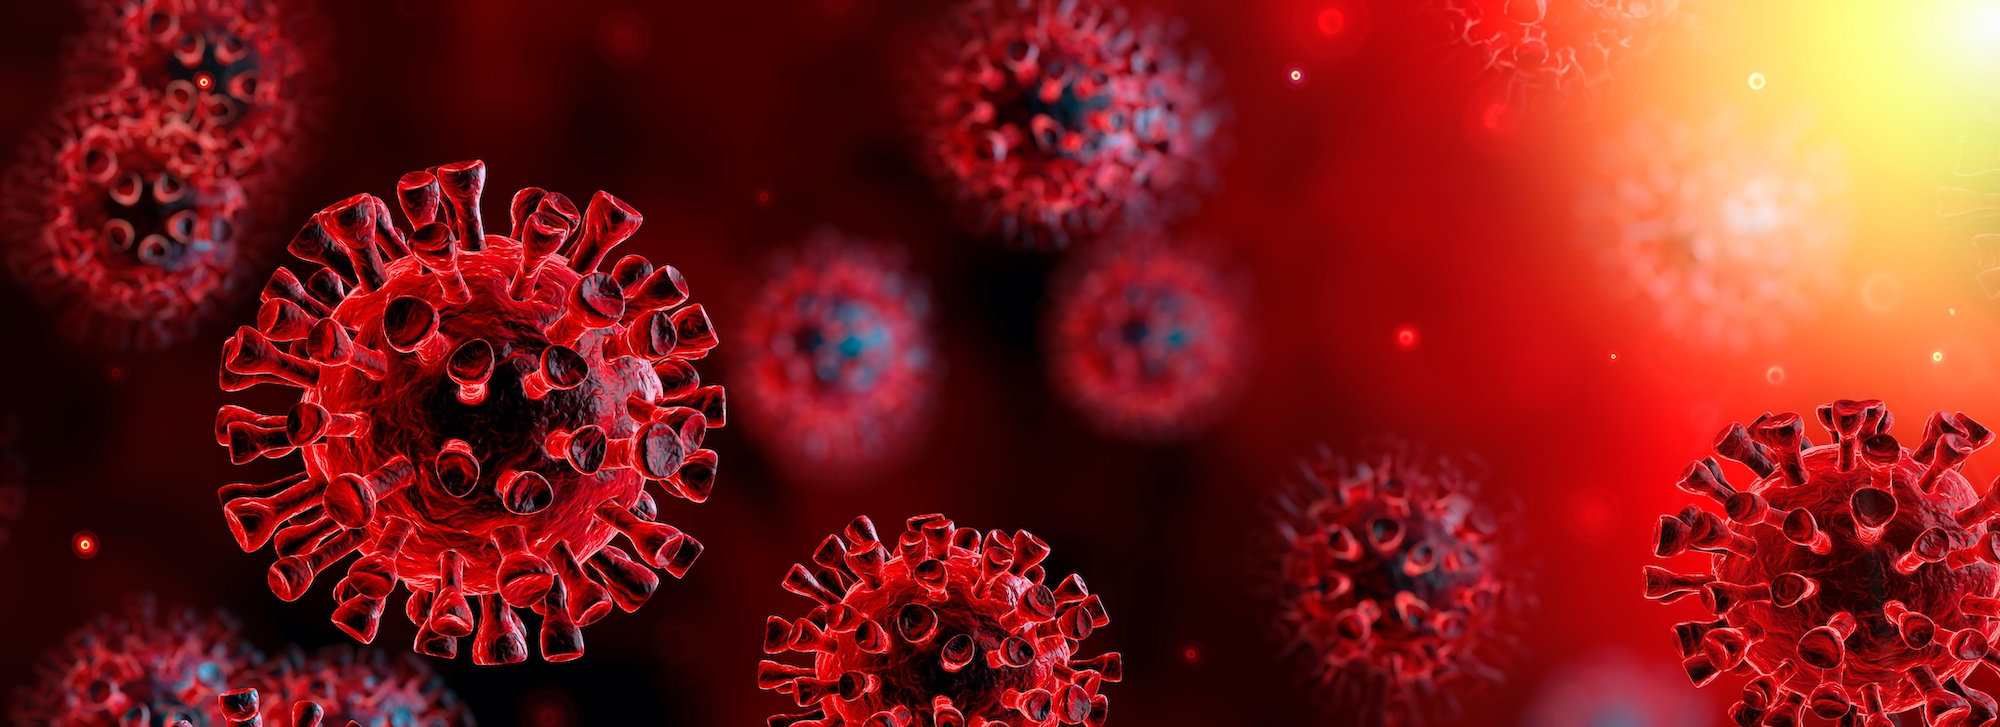

<br>On January 21, 2020, the COVID-19 virus first made landfall on American shores in a community just north of where I live in Seattle, Washington. Since then, over 246,000 lives have been lost, and over 11 million people have contracted the virus and could live with permanent health outcomes. Due to the current political climate in the United States-- and the fact the president himself is an adamant COVID denialist-- many activitites that impact the transmission of COVID-19 have been politicized.

<br>The Roche Data Science Coalition (RDSC) is requesting the collaborative effort of the AI community to fight COVID-19, in what they are calling the UNCOVER challenge. UNCOVER, which stands for United Network for COVID Data Exploration and Research, in part seeks to identify which populations are at the greatest risk for COVID19.

<br>Combining county-level data on health, socioeconomics, and weather can help us identify which populations are at risk for COVID19 and help prepare high-risk communities.

<br>As such, in the spirit of the UNCOVER challenge, and in a sincere desire to help communities across this country, I am aiming to answer one question: what factors contribute to COVID transmission and death, and where are the populations most at risk?

# **Methodology**

<a href="https://www.kaggle.com/johnjdavisiv/us-counties-weather-health-covid19-data" target="_blank">A full description of the data source can be found on Kaggle.</a>

<br>Data sources include:
* New York Times county-level COVID19 case and fatality data (part of UNCOVER data)
* 2016 CDC Social Vulnerability Data (part of UNCOVER data)
* 2020 Community Health Rankings Data (part of UNCOVER data)
* NOAA Global Surface Summary of the Day (GSOD) weather data for 2020
* Each county is paired with the nearest weather station. Most stations are within 50 km of the county center, and virtually all are within 100 km of the county center
* Kaiser Family Foundation Data on state-level stay-at-home orders

<br>In order to properly sort counties into low-, medium-, and high-risk categories, I first had to define whether infection or death was the more negative outcome. Ultimately, I decided that neither exists in a vacuum, and both pose their own unique risks to a population:
* Living in a county with high TRANSMISSION can lead to inundation of hospitals and clinics, ultimately putting a squeeze on the health resources of the county. This can lead to an increase in non-COVID deaths. Further, even those who do not die from COVID don't escape many long-term effects. 
* Living in a county with high DEATH rates could suggest an especially vulnerable population. Further, it could also suggest that a hospital system is already inundated.

<br>As a result, I chose to look at the intersection of both metrics to determine the overall risk that COVID presents to a community. Because when we are discussing the impacts of transmission and death we are looking at exceedingly small percentages, I instead chose to use the equations:

* **Infection Rate:** Population/Infections <br>
* **Death Rate:** Population/Deaths

<br>These equations produce a result that could be framed as "*1 out of every X citizens*." This felt more accessible to the general population. Each county was then ranked from worst to best for infection rate and death rate. Those is the worse-off 50th percentile received a score of "1" for that risk factor.
* **Infection Risk:** A "1" was issued if more than 1 out of every 50 citizens had at some point been infected. <br>
* **Death Risk:** A "1" was issued if more than 1 out of every 2000 citizens had died of COVID-19. 

<br>These numbers were then combined into a target metric known as the **Risk Score**. Each Risk Score is understood to mean the following:
* **Risk Score of 0:** These counties have both a slower-than-average infection and death risk. There may be factors in play that are slowing both the rates of transmission and death.
* **Risk Score of 1:** These counties have a higher-than-average infection OR death risk. This represents the vast majority of counties.
* **Risk Score of 2:** These cou nties have both a higher-than-average infection and death risk. There may be factors in play that are speeding up both the rates of transmission and death.

<br> Because this is a classification problem that has both an obviously desireable class and an obviously undesireable class, the success metrics for each class are different. I chose to only focus on the Risk Scores of 0 and 2, as those in the 1 category provide fewer insights into potential protective factors or risk factors:
* **Risk Score of 0:** Because these counties have the most desireable outcome, we want to maximize **PRECISION**. We want to have a very high threshold for declaring a county as "low-risk", because to erroneously declare a county as low-risk when they are, in-fact, of moderate risk could provide a false sense of security for its citizenry. While this exclude counties that are, in fact, low-risk, in this instance, we would prefer to have a smaller population considered to be "safe." 
* **Risk Score of 2:** Because these counties have the least desireable outcome, we want to maximize **RECALL**. We want to have a very low threshold for declaring a county as "high-risk", because to erroneously declare a county as NOT high-risk when they in-fact are could minimize the action taken by the citizenry to protect their health. While this may include counties that are medium-risk into the high-risk group, in this instance, we would prefer to have a larger population considered to be "in danger."

# **COVID-19 Risk Factor Model**

##**Importing Libraries & Generating Functions**

###**Install Necessary Libraries and Packages**

Google Colab does not come with descarts or geopandas pre-installed, so I kept these lines of code to ensure any viewers of this notebook could run the below code and have it work as expected.

In [ ]:
!pip install descartes
!pip install geopandas

     |████████████████████████████████| 972kB 5.8MB/s 
     |████████████████████████████████| 14.8MB 322kB/s 
     |████████████████████████████████| 6.5MB 40.2MB/s 


In [ ]:
#mathematical libraries
import pandas as pd 
import numpy as np
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm

#vizualization libraries
import matplotlib.pyplot as plt
%matplotlib inline 
import seaborn as sns
sns.set(style="white")
sns.set_palette("Spectral")
sns.set_context("paper")
import missingno as msno
import geopandas as gpd

#sci-kit learn
from sklearn import metrics
from sklearn import model_selection
from sklearn import preprocessing
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold, SelectFromModel, RFECV
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import accuracy_score, auc, classification_report, confusion_matrix, roc_curve
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import MinMaxScaler, MultiLabelBinarizer, PolynomialFeatures
from sklearn.svm import SVC
from sklearn.utils import class_weight

#xgb libraries
import xgboost as xgb
from xgboost import XGBClassifier

### **Generate Functions to Streamline Code**

Each function below was created to faciliate the process of building and iterating over several models.

#### **csv_import()**

In [ ]:
def csv_import(csv):
    '''Loads the requested csv file, and provides its shape, summary information, and count of null values
    
        @params
        csv is a .csv file
        df is a pd.DataFrame
        
        @output
        a pd.Dataframe
    
    '''
    df = pd.read_csv(csv)
    print('DATAFRAME SHAPE')
    print("================================================================================")
    print(df.shape)
    print("")
    print('DATA SUMMARY')
    print("================================================================================")
    print(df.info())
    print("")
    print("VALUE COUNTS FOR COLUMNS WITH NULL VALUES")
    print("================================================================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "/ VALUE COUNTS")
        print("----------------------------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    print("")
    print("MISSING VALUES VISUALIZATION")
    print("================================================================================") 
    msno.bar(df)
    return df

#### **explore_y()**

In [ ]:
def explore_y(df,y):
    '''Explores the counts of all possible y values
    
        @params
        y is a column of df
        
        @output
        a count plot
    
    '''
    df[y].value_counts()
    sns.countplot(x=y, data=df)
    sns.despine()
    plt.show();

#### **run_exps()**

In [ ]:
def run_exps(X_train: pd.DataFrame , y_train: pd.DataFrame, X_test: pd.DataFrame, y_test: pd.DataFrame) -> pd.DataFrame:
    '''Explores several common modeling types, and provides comparative features for model selection

        @params
        X_train, X_test, y_train, and y_test are the resultant datasets from the test_train_split action
        
        @output
        visualization comparing several models by initial accuracy, precision, recall, f1 and roc_auc
        visualization comparing several models by fit and score times 
    
    '''
    
    dfs = []
    models = [
          ('LogReg', LogisticRegressionCV()), 
          ('RF', RandomForestClassifier()),
          ('KNN', KNeighborsClassifier()),
          ('SVM', SVC()), 
          ('GNB', GaussianNB()),
          ('XGB', XGBClassifier())
        ]
    
    results = []
    names = []
    scoring = ['accuracy', 'precision_weighted', 'recall_weighted', 'f1_weighted', 'roc_auc']
    target_names = ['below average risk', 'above average risk']
    
    for name, model in models:
        kfold = model_selection.KFold(n_splits=5, shuffle=True, random_state=0)
        cv_results = model_selection.cross_validate(model, X_train, y_train, cv=kfold, scoring=scoring)
        clf = model.fit(X_train, y_train)
        y_pred = clf.predict(X_test)
        print(name)
        print(classification_report(y_test, y_pred, target_names=target_names))
    
        results.append(cv_results)
        names.append(name)
    
        this_df = pd.DataFrame(cv_results)
        this_df['model'] = name
        dfs.append(this_df)
    
    final = pd.concat(dfs, ignore_index=True)
    
    bootstraps = []
    for model in list(set(final.model.values)):
        model_df = final.loc[final.model == model]
        bootstrap = model_df.sample(n=30, replace=True)
        bootstraps.append(bootstrap)
        
    bootstrap_df = pd.concat(bootstraps, ignore_index=True)
    results_long = pd.melt(bootstrap_df,id_vars=['model'],var_name='metrics', value_name='values')
    time_metrics = ['fit_time','score_time'] # fit time metrics

    results_long_nofit = results_long.loc[~results_long['metrics'].isin(time_metrics)] # get df without fit data
    results_long_nofit = results_long_nofit.sort_values(by='values')

    results_long_fit = results_long.loc[results_long['metrics'].isin(time_metrics)] # df with fit data
    results_long_fit = results_long_fit.sort_values(by='values')

    fig, ax = plt.subplots(1, 2, figsize=(20, 7))
    fig.suptitle("Model Evaluation Metrics")
    sns.despine()

    g = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_nofit, palette="Spectral", ax=ax[0])
    g.legend(loc=4)
    g.set_title('Comparison of Model by Classification Metric')
    g.set_xlabel('Model')
    g.set_ylabel('Score')
    g.set_yticklabels(g.get_yticklabels())
    g.set_xticklabels(g.get_xticklabels())


    h = sns.boxplot(x="model", y="values", hue="metrics", data=results_long_fit, palette="Spectral", ax=ax[1])
    h.legend(loc=1)
    h.set_title('Comparison of Model by Fit and Score Time')
    h.set_xlabel('Model')
    h.set_ylabel('Time')
    h.set_yticklabels(h.get_yticklabels())
    h.set_xticklabels(h.get_xticklabels())

    fig.show()

#### **run_model()**

In [ ]:
def run_model(model, X_train, X_test, y_train, y_test):  
    '''Loads a model, training and test data, and provides the model hyperparameters, as well as several accuracy metrics
    
        @params
        model is the instantialted model, such as the logreg in the code "logreg = LogisticRegressionCV()"
        X_train, X_test, y_train, and y_test are the resultant datasets from the test_train_split action
        
        @output
        model hyper parameters
        accuracy, r-squared, rmse and auc scores
        classification matrix
        confusion matrix
        roc curve graph
    
    '''
    target_names = ['below average risk', 'above average risk']
    log = model.fit(X_train, y_train)
    y_score = logreg.fit(X_train, y_train).decision_function(X_test)

    fpr, tpr, thresholds = roc_curve(y_test, y_score)

    y_pred_test = model.predict(X_test)
    y_pred_train = model.predict(X_train)

    training_accuracy = accuracy_score(y_train, y_pred_train)
    val_accuracy = accuracy_score(y_test, y_pred_test)

    print("")
    print('MODEL HYPERPARAMETERS')
    print("================================================================================")
    print(log)
    print("")
    print("")
    print('ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC')
    print("================================================================================")
    print("Training Accuracy: {:.4}%".format(training_accuracy * 100))
    print('Training R-Squared: ', model.score(X_train, y_train))
    print('Training Root Mean Square Error', np.sqrt(metrics.mean_squared_error(y_train, y_pred_train)))
    print("")
    print("Validation accuracy: {:.4}%".format(val_accuracy * 100)) 
    print('Validation R-Squared: ', model.score(X_test, y_test))
    print('Validation Root Mean Square Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred_test)))
    print("")
    print('AUC: {}'.format(auc(fpr, tpr)))
    print("")
    print("")
    print("CLASSIFICATION REPORT, CONFUSION MATRIX and ROC")
    print("================================================================================")
    print(classification_report(y_test, y_pred_test, target_names = target_names))
    
    fig, ax = plt.subplots(1, 2, figsize=(12, 4))

    sns.despine()

    cm = confusion_matrix(y_test, y_pred_test)
    group_names = ['True Negative','False Positive','False Negative','True Positive']
    group_counts = ["{0:0.0f}".format(value) for value in cm.flatten()]
    labels = [f"{v1}\n{v2}" for v1, v2 in zip(group_names,group_counts)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cm, annot=labels, fmt='', cmap="Spectral", ax=ax[0])

    sns.lineplot(x=fpr, y=tpr, color="darkorange", estimator=None, ax=ax[1])
    plt.xlim([0.0, 1.05])
    plt.ylim([0.0, 1.05])
    plt.yticks([i/10.0 for i in range(11)])
    plt.xticks([i/10.0 for i in range(11)])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')

    ax[1].twinx()
    sns.lineplot(x=[0, 1], y=[0, 1], color="darkblue")

    plt.tight_layout()

    fig.show()

#### **validate_changes()**

In [ ]:
def validate_changes(df):
    '''Loads the requested df, and provides its shape and count of null values; should be run after initial
        transformation
    
        @params
        df is a pd.DataFrame
        
        @output
        summary data
    '''
    print('DATAFRAME SHAPE')
    print("================================================================================")
    print(df.shape)
    print("")
    print("COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION")
    print("(Should Produce No Results Below Line)")
    print("================================================================================")      
    null_cols = []
    for col in df.columns:
        if df[col].isna().sum() > 0:
            null_cols.append(col)
    for col in null_cols:
        print(col, "VALUE COUNTS")
        print("----------------------------------------")
        print(df[col].value_counts(dropna=False))  
        print("")
    print("")
    return df.head()

#### **variance_test()**

In [ ]:
def variance_test(model, X_train, X_test, y_train, y_test, low_thresh, high_thresh, num):
    threshold_ranges = np.linspace(low_thresh, high_thresh, num=num)
    '''iterate over a number of VarianceThreshold() tests 
    
        @params
        model is the instantialted model, such as the logreg in the code "logreg = LogisticRegressionCV()"
        X_train, X_test, y_train, and y_test are the resultant datasets from the test_train_split action
        low_thresh and high_thresh are the minimum and maximum thresholhds to be considered by VarianceThreshold()
        num is the number of iterations between low_thresh and high_thresh
        
        @output
        run_model() outputs for a number of iterations as indicated in num
    
    '''
    for thresh in threshold_ranges:
        print("THRESHOLD: ", thresh)
        print("========================================")
        selector = VarianceThreshold(thresh)
        reduced_feature_train = selector.fit_transform(X_train)
        reduced_feature_test = selector.transform(X_test)
        model = model
        model.fit(reduced_feature_train, y_train)
        run_model(model, reduced_feature_train, reduced_feature_test, y_train, y_test)
        print('')
        print('')

##**Map Current State**

Before any cleaning of my data, I wanted to create a baseline understanding of where risk_scores of 0 and 2 were located. I also generate the merged dataframe that will be used in final data analysis but NOT touched during the modeling process.

In [ ]:
#import a copy of the data
data_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/COVID Datasets/US_counties_COVID19_health_weather_data.csv')

#set the filepath and load in a shapefile
fp = ('/content/drive/My Drive/Colab Notebooks/COVID Datasets/cb_2019_us_county_500k.shp')
map_df = gpd.read_file(fp)

#maintain leading 0s
map_df['GEOID'] = map_df['GEOID'].apply(lambda x: '{0:0>5}'.format(x))
data_df['fips'] = data_df['fips'].apply(lambda x: '{0:0>5}'.format(x))

#merge dataframes
merged = map_df.set_index('GEOID').join(data_df.set_index('fips'))

#clean up nans
merged.replace('nan', np.nan, inplace=True)

#create a copy of risk_target
merged.loc[:, 'risk'] = merged.loc[:, 'risk_target']

#make risk_target discrete and rename for map graphic
merged['risk_target'] = merged.risk_target.astype(str)
merged['risk_target'].replace(('0.0', '1.0', '2.0'), ('Below Average Transmission & Death', 'Average Transmission and/or Death', 
                                                      'Above Average Transmission & Death'), inplace=True)
indexNames = merged[merged['risk_target'] == 'nan'].index
merged.drop(indexNames, inplace=True)
variable = merged['risk_target']

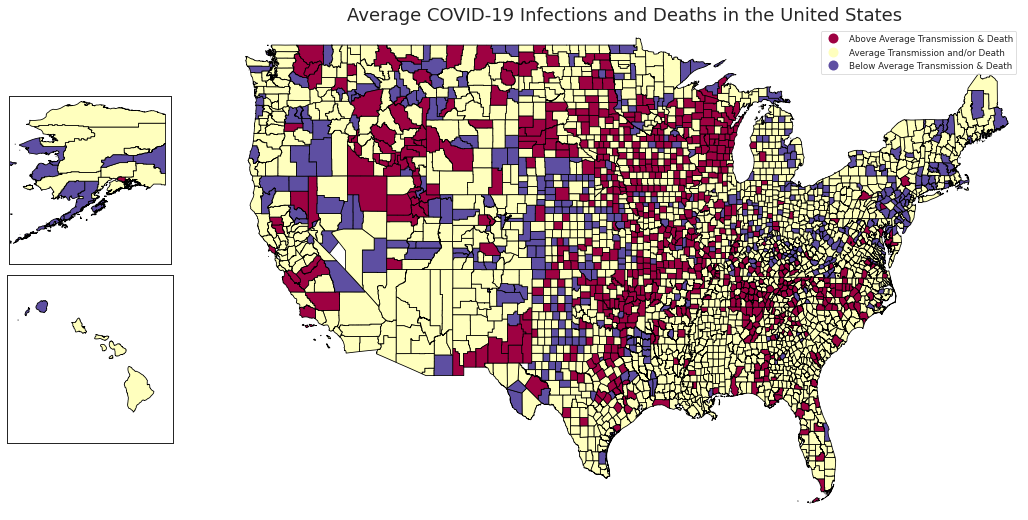

In [ ]:
#build map
fig = plt.figure(figsize=(15, 15))
 
ax1 = plt.subplot2grid((6,4), (0,1), rowspan=6, colspan=3)
ax1 = merged.plot(column=variable, cmap='Spectral', ax=ax1, edgecolor='black', legend=True)
ax1.set_title('Average COVID-19 Infections and Deaths in the United States', fontsize=18)
ax1.set_xlim(-126, -66)
ax1.set_ylim(24, 50)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')
 
ax2 = plt.subplot2grid((6,4), (2,0), rowspan=1, colspan=1)
ax2 = merged.plot(column=variable, cmap='Spectral', ax=ax2, edgecolor='black')
ax2.set_xlim(-170, -140)
ax2.set_ylim(50, 72)
ax2.set_xticks([])
ax2.set_yticks([])
 
ax3 = plt.subplot2grid((6,4), (3,0), rowspan=1, colspan=1)
ax3 = merged.plot(column=variable, cmap='Spectral', ax=ax3, edgecolor='black')
ax3.set_xlim(-161, -154)
ax3.set_ylim(18, 23)
ax3.set_xticks([])
ax3.set_yticks([])
 
fig.tight_layout()
plt.show();

## **Import and Clean Data**

After creating a map to understanding our starting place, I created a new dataframe that would be used for the duration of modeling. The output provides the the shape of the data, as well as a summary, the value counts of any columns with missing data, as well as a data visualization of how much data is missing from each column.

DATAFRAME SHAPE
(3134, 233)

DATA SUMMARY
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3134 entries, 0 to 3133
Columns: 233 entries, county to date_stay_at_home_effective
dtypes: float64(181), int64(42), object(10)
memory usage: 5.6+ MB
None

VALUE COUNTS FOR COLUMNS WITH NULL VALUES
num_deaths / VALUE COUNTS
----------------------------------------
NaN       288
169.0      10
94.0        9
211.0       9
104.0       9
         ... 
2914.0      1
1837.0      1
1711.0      1
1737.0      1
5749.0      1
Name: num_deaths, Length: 1464, dtype: int64

years_of_potential_life_lost_rate / VALUE COUNTS
----------------------------------------
NaN             288
6868.158342       1
10314.971570      1
9600.661267       1
8762.327259       1
               ... 
9054.905988       1
8032.851827       1
9709.049172       1
6861.376437       1
10052.016080      1
Name: years_of_potential_life_lost_rate, Length: 2847, dtype: int64

percent_low_birthweight / VALUE COUNTS
-------------------------

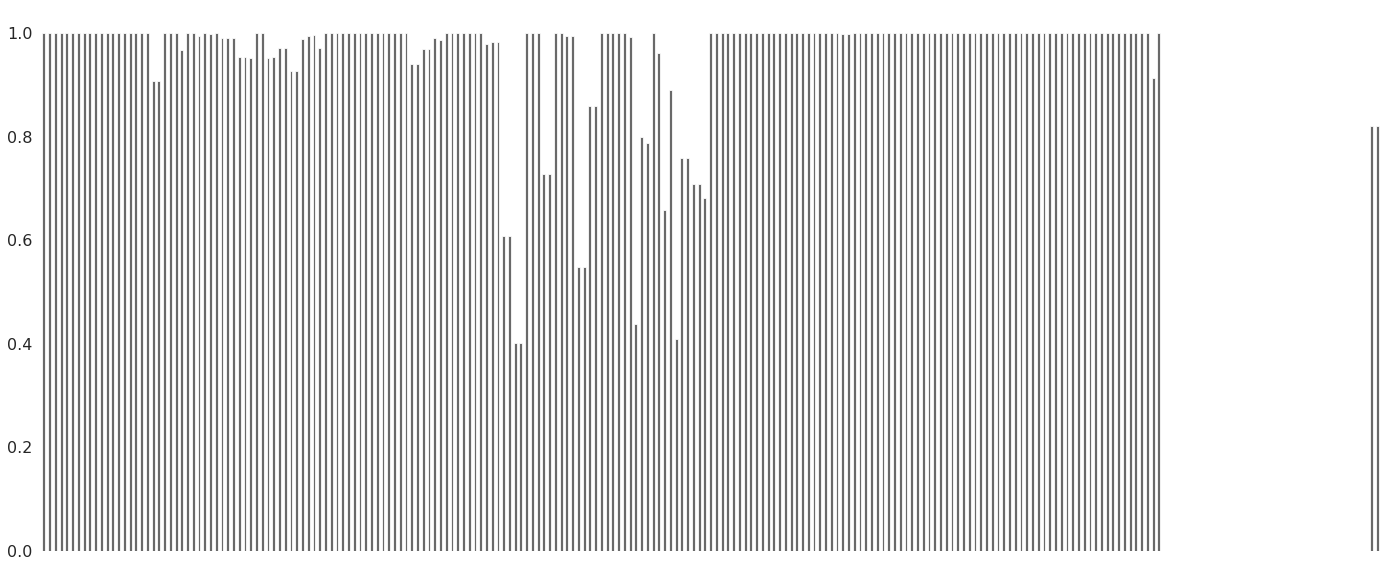

In [ ]:
df = csv_import('/content/drive/MyDrive/Colab Notebooks/COVID Datasets/US_counties_COVID19_health_weather_data.csv')

Unfortunately, much of the data that was missing was weather data, meaning weather/climate would not play as significant of a role in my model. The one "pro" of losing this data was I no longer needed to account for certain regional non-causal correlations, such as high temperatures and lower-than-average health outcomes in the American southeast.

In [ ]:
#change yes/no and true/false to 0/1
df.replace(('yes', 'no'), (1, 0), inplace=True)
df['presence_of_water_violation'] = df.presence_of_water_violation.astype(float)

#replace nan values with 0 in num_deaths
df['num_deaths'] = df['num_deaths'].fillna(0)

#drop values with more than 10% NaNs:
df = df.dropna(thresh=len(df) * .9, axis=1)

#fill remaining NaNs with median:
df = df.fillna(df.median())

#drop informational data
df = df.drop(['fips','CALL'], axis=1)

#drop data that was used to create "risk_target" metric
df = df.drop(['cases_percent_of_pop', 'case_target','cases_1_of_x','deaths_percent_of_pop','death_target',
             'deaths_1_of_x','num_deaths', 'years_of_potential_life_lost_rate'], axis=1)

Before moving forward, I used my validate_changes() function to verify that no nulls persisted through transformation.

In [ ]:
validate_changes(df)

DATAFRAME SHAPE
(3134, 164)

COLUMNS THAT STILL HAVE NULL VALUES AFTER TRANSFORMATION
(Should Produce No Results Below Line)



,county,state,risk_target,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,...,num_mobile_homes,num_overcrowding,num_households_with_no_vehicle,num_institutionalized_in_group_quarters,percent_below_poverty,percent_unemployed_CDC,percent_no_highschool_diploma,percent_age_65_and_older,percent_age_17_and_younger,percent_disabled,percent_single_parent_households_CDC,percent_minorities,percent_limited_english_abilities,percent_multi_unit_housing,percent_mobile_homes,percent_overcrowding,percent_no_vehicle,percent_institutionalized_in_group_quarters,percentile_rank_below_poverty,percentile_rank_unemployed,percentile_rank_per_capita_income,percentile_rank_no_highschool_diploma,percentile_rank_socioeconomic_theme,percentile_rank_age_65_and_older,percentile_rank_age_17_and_younger,percentile_rank_disabled,percentile_rank_single_parent_households,percentile_rank_household_comp_disability_theme,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,km_to_closest_station,ELEV_M
0,Chattahoochee,Georgia,2,1735,1,1,1,32.346992,-84.787030,11882,248.735662,47.769588,19.655826,3.693457,3.804301,6.710098,17.965195,34.7,4.4,22.2,83.660247,22.907405,3.0,10.0,30.000000,26.0,251.4,46.460177,877,12.133370,8.0,77.347000,76.0,711.34407,32.0,111.931315,2514.0,35.0,37.0,82.142857,...,556,68,161,3594,14.3,16.0,9.8,3.9,23.1,15.5,9.9,40.0,1.8,1.7,16.6,2.6,6.2,30.2,0.4094,0.9834,0.8402,0.2837,0.6711,0.0000,0.5740,0.5107,0.7246,0.3343,0.8071,0.7364,0.8268,0.3196,0.6905,0.7093,0.5495,0.9946,0.8660,0.7752,20.031326,70.7
1,Lake,Tennessee,2,980,3,1,1,36.335254,-89.493541,7643,165.784957,46.101891,26.804350,5.191350,5.010597,11.185682,28.078959,37.4,6.8,30.5,23.046476,14.047171,1.0,3.0,33.333333,58.0,776.6,73.081608,458,11.648016,13.0,48.289805,1.0,13.49346,1.0,13.493460,8884.0,32.0,35.0,96.226415,...,239,35,321,2721,29.2,12.2,26.9,15.1,15.3,25.8,13.8,32.5,0.3,3.8,9.2,1.6,15.0,35.6,0.9577,0.9408,0.9940,0.9602,0.9889,0.2732,0.0156,0.9771,0.9647,0.6632,0.7249,0.2267,0.4674,0.6141,0.4253,0.4101,0.9793,0.9978,0.9140,0.9271,50.262400,79.9
2,Ford,Kansas,2,3343,10,1,1,37.691721,-99.887969,34492,1098.270322,31.405747,19.642222,3.585448,3.454001,6.772463,16.954345,30.9,8.7,27.1,77.797802,16.269463,2.0,28.0,7.142857,145.0,421.7,52.985603,5377,18.024873,14.0,40.720170,18.0,53.11615,33.0,97.379600,3704.0,37.0,38.0,91.400000,...,1461,667,763,673,17.4,7.2,28.8,10.5,30.7,10.1,12.2,58.4,12.2,5.7,12.1,5.9,6.8,2.0,0.6097,0.5552,0.7705,0.9745,0.7800,0.0388,0.9755,0.0707,0.9207,0.4798,0.9252,0.9834,0.9748,0.7491,0.5466,0.9526,0.6425,0.5005,0.9048,0.9039,11.119969,787.0
3,Wayne,Tennessee,2,1584,7,1,1,35.239918,-87.788056,16842,734.101526,22.942331,23.832402,4.720932,4.764835,8.059701,24.667945,34.7,7.4,40.7,70.789025,13.667219,5.0,15.0,33.333333,41.0,247.2,33.333333,1341,11.841060,5.0,30.151360,1.0,6.03938,4.0,24.157510,5925.0,34.0,45.0,96.341463,...,1580,81,231,2051,18.9,8.4

Because the UNCOVER dataset was robust in its number of features, I chose to rely on PolynomialFeatures() during the modeling process to manufacture further features. As such, I moved forward to exploring the distrubition of my risk_factor scores.

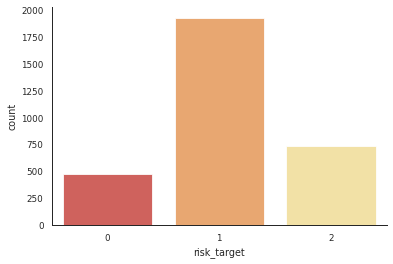

In [ ]:
explore_y(df,'risk_target')

Because I believe that counties with risk_factors of 0 and 2 will be the most telling, I drop all counties with a value of 1, and then replace the risk_factors of 2 to 1 to make it a binary classification problem.

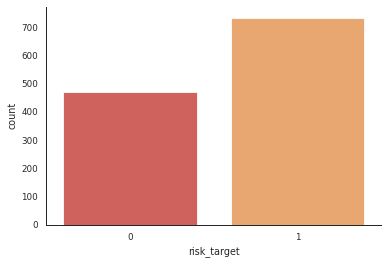

In [ ]:
indexNames = df[df['risk_target']==1].index
df.drop(indexNames, inplace=True)
df['risk_target'].replace(2, 1, inplace=True)
explore_y(df,'risk_target')

## **Model Selection**

I leverage the run_exps() method to determine the classification matrix for each potential model, as well as visual representations of starting evaluation metrics and speed. Given the high number of features, there would necessarily be an accuracy-to-speed tradeoff.

LogReg
                    precision    recall  f1-score   support

below average risk       0.76      0.79      0.78        99
above average risk       0.85      0.83      0.84       143

          accuracy                           0.81       242
         macro avg       0.81      0.81      0.81       242
      weighted avg       0.82      0.81      0.81       242

RF
                    precision    recall  f1-score   support

below average risk       0.78      0.79      0.78        99
above average risk       0.85      0.85      0.85       143

          accuracy                           0.82       242
         macro avg       0.82      0.82      0.82       242
      weighted avg       0.82      0.82      0.82       242

KNN
                    precision    recall  f1-score   support

below average risk       0.69      0.58      0.63        99
above average risk       0.74      0.82      0.77       143

          accuracy                           0.72       242
         macro avg

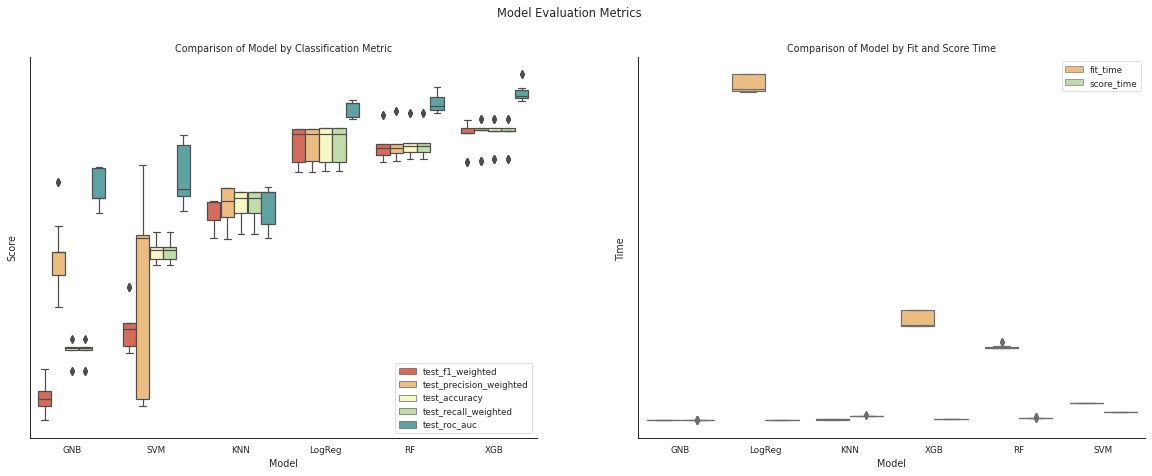

In [ ]:
y = df['risk_target']
X = df.drop(columns=['county','state','cases','deaths','risk_target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)

run_exps(X_train, y_train, X_test, y_test)

Based on comparing initial scores to speed, I immediately removed GNB, SVM, and KNN from contention. Ultimately, I decided that I wanted to try LogReg and XGB models.

## **Logistic Regression with Cross Validation Model**

### **Vanilla/Baseline Model**

In [ ]:
y = df['risk_target']
X = df.drop(columns=['county','state','cases','deaths','risk_target'], axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0)


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 82.78%
Training R-Squared:  0.8278008298755186
Training Root Mean Square Error 0.41496887850112485

Validation accuracy: 81.4%
Validation R-Squared:  0.8140495867768595
Validation Root Mean Square Error: 0.4312196809320517

AUC: 0.8740552376916014


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.76      0.79      0.78        99
above average risk       0.85      0.83      0.84       143

          accuracy                           0.81       242
      

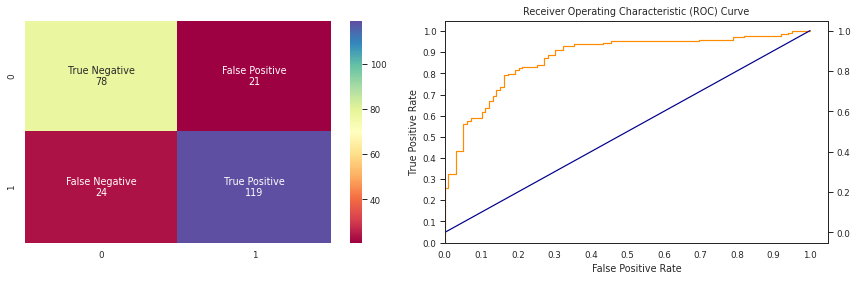

In [ ]:
logreg = LogisticRegressionCV() 
run_model(logreg, X_train, X_test, y_train, y_test)

### **Scaled Data**

I went with MinMaxScaler() with bounds of 0 and 1 to speed up my calculations and normalize the widely varying numbers within a limited range.

In [ ]:
#scale training data
scaler = MinMaxScaler()
transformed_training_features = scaler.fit_transform(X_train.fillna(0))
X_train_transformed = pd.DataFrame(transformed_training_features, columns=X_train.columns)

#scale testing data
scaler = MinMaxScaler()
transformed_testing_features = scaler.fit_transform(X_test.fillna(0))
X_test_transformed = pd.DataFrame(transformed_testing_features, columns=X_test.columns)

X_test_transformed.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,num_mobile_homes,num_overcrowding,num_households_with_no_vehicle,num_institutionalized_in_group_quarters,percent_below_poverty,percent_unemployed_CDC,percent_no_highschool_diploma,percent_age_65_and_older,percent_age_17_and_younger,percent_disabled,percent_single_parent_households_CDC,percent_minorities,percent_limited_english_abilities,percent_multi_unit_housing,percent_mobile_homes,percent_overcrowding,percent_no_vehicle,percent_institutionalized_in_group_quarters,percentile_rank_below_poverty,percentile_rank_unemployed,percentile_rank_per_capita_income,percentile_rank_no_highschool_diploma,percentile_rank_socioeconomic_theme,percentile_rank_age_65_and_older,percentile_rank_age_17_and_younger,percentile_rank_disabled,percentile_rank_single_parent_households,percentile_rank_household_comp_disability_theme,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,km_to_closest_station,ELEV_M
0,0.0,0.0,0.168193,0.654877,0.028309,0.122602,0.005112,0.437687,0.513744,0.706086,0.268360,0.539820,0.656140,0.415094,0.547826,0.741366,0.181087,0.207547,0.156627,0.415094,0.029313,0.324719,0.637118,0.069863,0.638004,0.010453,0.165026,0.014475,0.168334,0.036954,0.537205,0.264635,0.466667,0.642857,0.726012,0.015172,0.024599,0.369010,0.027506,0.019083,...,0.193010,0.034248,0.016579,0.037509,0.386423,0.395683,0.288835,0.350554,0.508333,0.771689,0.562914,0.339690,0.020067,0.038636,0.323789,0.243902,0.339286,0.138122,0.618751,0.362115,0.576432,0.560729,0.544143,0.589360,0.466895,0.911696,0.629957,0.871211,0.705048,0.421453,0.567905,0.315705,0.637381,0.553148,0.480609,0.809753,0.630677,0.698655,0.034747,0.077979
1,0.0,0.0,0.490017,0.613185,0.001327,0.092147,0.000316,0.046689,0.063250,0.030424,0.272972,0.241868,0.698246,0.509434,0.701449,0.046954,0.355233,0.018868,0.009036,0.500000,0.013709,0.213272,0.362015,0.001374,0.263797,0.000498,0.149083,0.000000,0.000000,0.003418,0.076252,0.483122,0.911111,0.232143,1.000000,0.000580,0.000777,0.556688,0.001081,0.000957,...,0.006064,0.000473,0.000548,0.005096,0.258486,0.021583,0.140777,0.619926,0.462500,0.438356,0.152318,0.054827,0.000000,0.040909,0.211454,0.060976,0.208333,0.353591,0.300743,0.002685,0.196136,0.142485,0.104732,0.948835,0.328119,0.397622,0.010677,0.247039,0.209102,0.000000,0.057989,0.332933,0.448961,0.044563,0.128020,0.960849,0.215840,0.076915,0.547695,0.131612
2,0.0,0.0,0.179128,0.606598,0.014685,0.084632,0.003850,0.352818,0.399614,0.517187,0.379212,0.458440,0.638596,0.698113,0.475362,0.650753,0.218011,0.037736,0.096386,0.121212,0.016042,0.372901,0.789292,0.031263,0.556432,0.007964,0.254918,0.006293,0.147925,0.007049,0.207112,0.236084,0.266667,0.732143,0.816819,0.008786,0.013790,0.395760,0.011611,0.012060,...,0.060923,0.013150,0.005575,0.027099,0.295039,0.215827,0.32


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 86.51%
Training R-Squared:  0.8651452282157677
Training Root Mean Square Error 0.36722577766849696

Validation accuracy: 77.27%
Validation R-Squared:  0.7727272727272727
Validation Root Mean Square Error: 0.4767312946227962

AUC: 0.8197358197358198


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.72      0.72      0.72        99
above average risk       0.81      0.81      0.81       143

          accuracy                           0.77       242
     

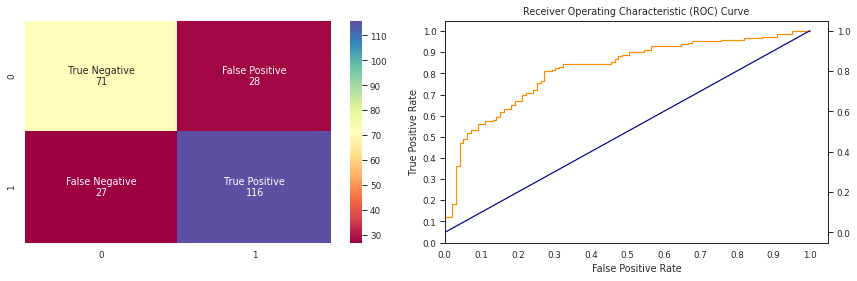

In [ ]:
#check results
logreg = LogisticRegressionCV()
run_model(logreg, X_train_transformed, X_test_transformed, y_train, y_test)

While each of my target metrics went down, this was to be expected given how tightly we bound all of the data.

### **Add Polynomial Features**

As noted earlier, because of the richness of the data provided, I believed polynomial features paired with L1/LASSO regularization would be the best way to efficiently create new features.

In [ ]:
#add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_poly_train = pd.DataFrame(poly.fit_transform(X_train_transformed), columns=poly.get_feature_names(X_train_transformed.columns))
X_poly_test = pd.DataFrame(poly.fit_transform(X_test_transformed), columns=poly.get_feature_names(X_test_transformed.columns))

X_poly_train.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,percentile_rank_multi_unit_housing percentile_rank_housing_and_transportation,percentile_rank_multi_unit_housing percentile_rank_social_vulnerability,percentile_rank_multi_unit_housing km_to_closest_station,percentile_rank_multi_unit_housing ELEV_M,percentile_rank_mobile_homes^2,percentile_rank_mobile_homes percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_no_vehicle,percentile_rank_mobile_homes percentile_rank_institutionalized_in_group_quarters,percentile_rank_mobile_homes percentile_rank_housing_and_transportation,percentile_rank_mobile_homes percentile_rank_social_vulnerability,percentile_rank_mobile_homes km_to_closest_station,percentile_rank_mobile_homes ELEV_M,percentile_rank_overcrowding^2,percentile_rank_overcrowding percentile_rank_no_vehicle,percentile_rank_overcrowding percentile_rank_institutionalized_in_group_quarters,percentile_rank_overcrowding percentile_rank_housing_and_transportation,percentile_rank_overcrowding percentile_rank_social_vulnerability,percentile_rank_overcrowding km_to_closest_station,percentile_rank_overcrowding ELEV_M,percentile_rank_no_vehicle^2,percentile_rank_no_vehicle percentile_rank_institutionalized_in_group_quarters,percentile_rank_no_vehicle percentile_rank_housing_and_transportation,percentile_rank_no_vehicle percentile_rank_social_vulnerability,percentile_rank_no_vehicle km_to_closest_station,percentile_rank_no_vehicle ELEV_M,percentile_rank_institutionalized_in_group_quarters^2,percentile_rank_institutionalized_in_group_quarters percentile_rank_housing_and_transportation,percentile_rank_institutionalized_in_group_quarters percentile_rank_social_vulnerability,percentile_rank_institutionalized_in_group_quarters km_to_closest_station,percentile_rank_institutionalized_in_group_quarters ELEV_M,percentile_rank_housing_and_transportation^2,percentile_rank_housing_and_transportation percentile_rank_social_vulnerability,percentile_rank_housing_and_transportation km_to_closest_station,percentile_rank_housing_and_transportation ELEV_M,percentile_rank_social_vulnerability^2,percentile_rank_social_vulnerability km_to_closest_station,percentile_rank_social_vulnerability ELEV_M,km_to_closest_station^2,km_to_closest_station ELEV_M,ELEV_M^2
0,1.0,1.0,0.244057,0.742978,0.026265,0.036238,0.007328,0.338965,0.301194,0.405608,0.287428,0.270990,0.811224,0.656566,0.589595,0.630479,0.469181,0.084282,0.072046,0.366337,0.015750,0.062048,0.351644,0.017684,0.492441,0.010451,0.102853,0.006797,0.031602,0.003140,0.015147,0.278249,0.56,0.677419,0.885263,0.018325,0.020369,0.446352,0.025635,0.021934,...,0.205393,0.224088,0.014185,0.008889,0.698287,0.709037,0.290216,0.447868,0.570817,0.622773,0.039423,0.024704,0.719952,0.294684,0.454763,0.579604,0.632361,0.040030,0.025085,0.120617,0.186139,0.237238,0.258832,0.016385,0.010267,0.287254,0.366111,0.399435,0.025285,0.015845,0.466616,0.509088,0.032227,0.020195,0.555426,0.035160,0.022033,0.002226,0.001395,0.000874
1,1.0,1.0,0.397250,0.709386,0.002216,0.029002,0.000822,0.225635,0.185535,0.277965,0.179349,0.305754,0.533163,0.797980,0.


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 89.52%
Training R-Squared:  0.8952282157676349
Training Root Mean Square Error 0.32368469879245937

Validation accuracy: 86.36%
Validation R-Squared:  0.8636363636363636
Validation Root Mean Square Error: 0.3692744729379982

AUC: 0.9166490075580984


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.86      0.80      0.83        99
above average risk       0.87      0.91      0.89       143

          accuracy                           0.86       242
     

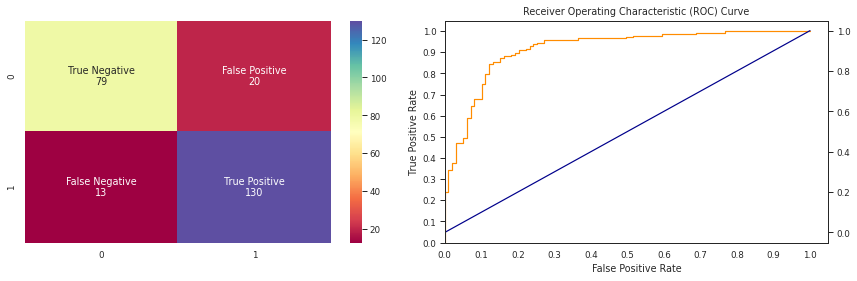

In [ ]:
#check results
logreg = LogisticRegressionCV()
run_model(logreg, X_poly_train, X_poly_test, y_train, y_test)

With the addition of polynomial features, there was a substantial improvement over the baseline model.

### **LASSO Regularization for Feature Selection**

I chose LASSO regression for feature selection because it could efficiently process my 12,000 features and, by reducing any unimportant coefficient to zero, allow me to focus in on only the data points that were the most telling in the set.

In [ ]:
#verify best solver for LASSO regularization
#param_grid = [
     #{'penalty' : ['l1'],
     #'solver' : ['liblinear', 'sag', 'saga', 'newton-cg','lbfgs'],
     #'fit_intercept' : [True, False],
     #'class_weight' : [None, 'balanced'],
     #'refit': [True, False]}
#]

#clf = GridSearchCV(estimator=LogisticRegressionCV(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

#best_model = clf.fit(X_poly_train, y_train)

#print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
#print('Best Fit_Intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
#print('Best Class_Weight:', best_model.best_estimator_.get_params()['class_weight'])
#print('Best Refit:', best_model.best_estimator_.get_params()['refit'])

####################
#RESULTS
####################
#Fitting 5 folds for each of 40 candidates, totalling 200 fits
#[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
#[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed: 73.2min
#[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 305.0min
#[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed: 309.4min finished
#Best Penalty: l1
#Best Solver: liblinear
#Best Fit_Intercept: True
#Best Class_Weight: None
#Best Refit: True

In [ ]:
#lasso regularization
selector1 = SelectFromModel(LogisticRegressionCV(solver='liblinear', penalty='l1'))
selector1.fit(X_poly_train, y_train)

selected_feat1 = X_poly_train.columns[(selector1.get_support())]
print('Total Features: {}'.format((X_poly_train.shape[1])))
print('Selected Features: {}'.format(len(selected_feat1)))

Total Features: 12879
Selected Features: 236


Less than 2% of all features were deemed important! This should greatly improve target metrics and reduce noise from superfluous data.

In [ ]:
#transform data
X_train_selected = pd.DataFrame(selector1.transform(X_poly_train), columns=selected_feat1)
X_test_selected = pd.DataFrame(selector1.transform(X_poly_test), columns=selected_feat1)

X_test_selected.head()

,percent_low_birthweight,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,average_traffic_volume_per_meter_of_major_roadways,num_mobile_homes,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced mental_health_provider_rate,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_unemployed_CHR,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_asian,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced num_age_65_and_older,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,stay_at_home_effective mental_health_provider_rate,stay_at_home_effective percent_vaccinated,...,num_rural percent_rural,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percent_limited_english_abilities^2,percent_institutionalized_in_group_quarters percentile_rank_disabled,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_unemployed ELEV_M,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_no_highschool_diploma ELEV_M,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentile_rank_limited_english_abilities percentile_rank_no_vehicle,percentile_rank_multi_unit_housing percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_housing_and_tra


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 95.02%
Training R-Squared:  0.950207468879668
Training Root Mean Square Error 0.22314240099168053

Validation accuracy: 81.82%
Validation R-Squared:  0.8181818181818182
Validation Root Mean Square Error: 0.4264014327112209

AUC: 0.906971816062725


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.87      0.66      0.75        99
above average risk       0.80      0.93      0.86       143

          accuracy                           0.82       242
       

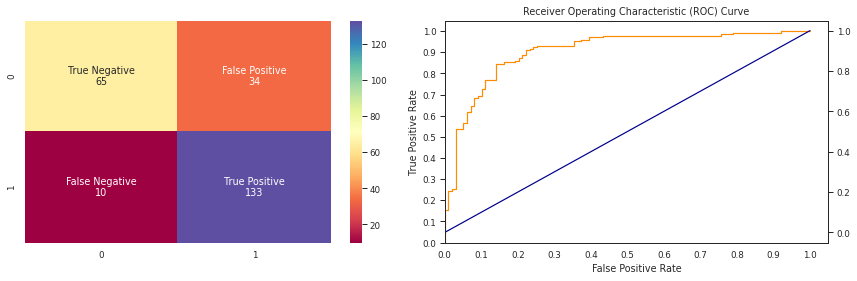

In [ ]:
logreg = LogisticRegressionCV()
run_model(logreg, X_train_selected, X_test_selected, y_train, y_test)

### **Variance Threshold Testing**

I was curious if I could trim additional features by applying VarianceThreshold() testing for feature selection. My goal was to only retain features that held strong predictive power, since these are the features we would need to use to allocate resources.

THRESHOLD:  0.0096

MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 93.88%
Training R-Squared:  0.9387966804979253
Training Root Mean Square Error 0.24739304659200648

Validation accuracy: 82.64%
Validation R-Squared:  0.8264462809917356
Validation Root Mean Square Error: 0.4165977904505309

AUC: 0.8917849826940736


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.91      0.64      0.75        99
above average risk       0.79      0.96      0.87       143

          accuracy                           0

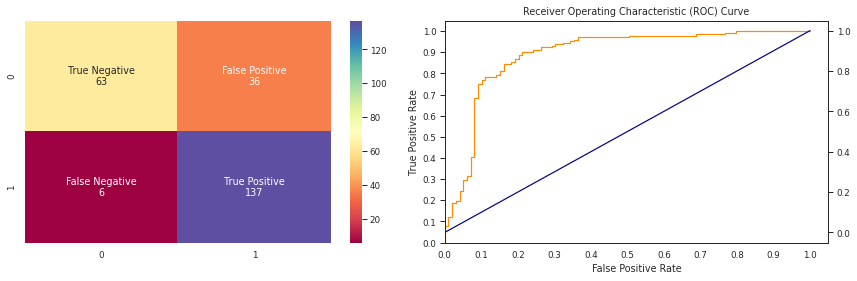

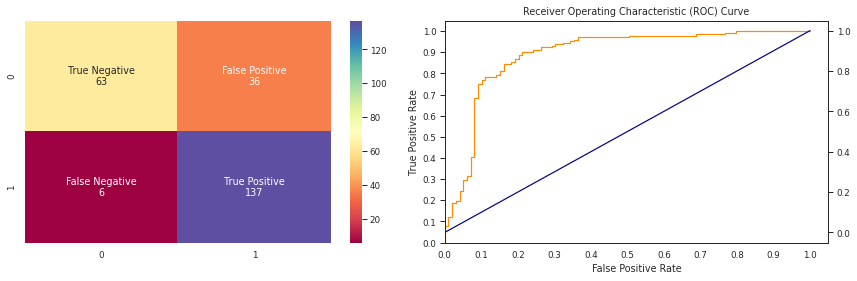

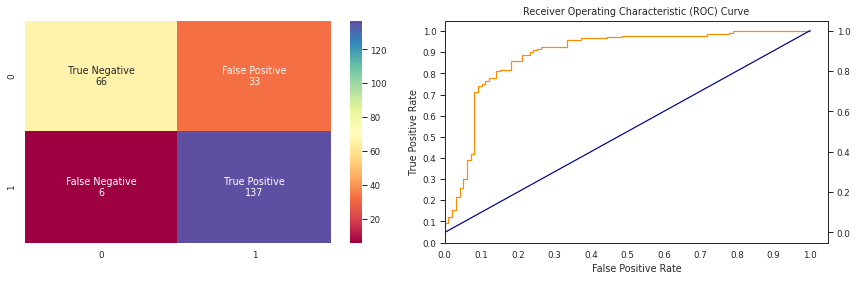

In [ ]:
#test various variance tresholds
#using low_thresh and high_thresh params, iterate using the method to narrow in on an appropriate value
variance_test(LogisticRegressionCV(), X_train_selected, X_test_selected, y_train, y_test, .0096, .0098, 3)

In [ ]:
#set ideal variance threshold
selector2 = VarianceThreshold(.0097)
selector2.fit(X_train_selected, y_train)

#generate list of selected features
selected_feat2 = X_train_selected.columns[(selector2.get_support())]

reduced_X_train = pd.DataFrame(selector2.transform(X_train_selected), columns=selected_feat2)
reduced_X_test = pd.DataFrame(selector2.transform(X_test_selected), columns=selected_feat2)

reduced_X_test.head()

,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,stay_at_home_effective percent_vaccinated,stay_at_home_effective percent_single_parent_households_CHR,stay_at_home_effective social_association_rate,stay_at_home_effective violent_crime_rate,stay_at_home_effective presence_of_water_violation,stay_at_home_effective percent_long_commute_drives_alone,stay_at_home_effective age_adjusted_death_rate,stay_at_home_effective percent_frequent_physical_distress,stay_at_home_effective percent_adults_with_diabetes,...,percent_enrolled_in_free_or_reduced_lunch percentile_rank_no_vehicle,percent_homeowners^2,percent_severe_housing_cost_burden^2,percent_non_hispanic_white percentile_rank_unemployed,percent_non_hispanic_white percentile_rank_multi_unit_housing,percent_non_hispanic_white percentile_rank_overcrowding,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentil


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=True, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='lbfgs', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 93.88%
Training R-Squared:  0.9387966804979253
Training Root Mean Square Error 0.24739304659200648

Validation accuracy: 82.64%
Validation R-Squared:  0.8264462809917356
Validation Root Mean Square Error: 0.4165977904505309

AUC: 0.8917849826940736


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.91      0.64      0.75        99
above average risk       0.79      0.96      0.87       143

          accuracy                           0.83       242
     

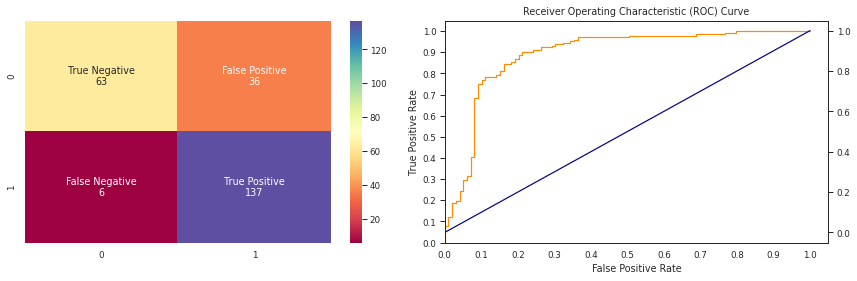

In [ ]:
logreg = LogisticRegressionCV()
run_model(logreg, reduced_X_train, reduced_X_test, y_train, y_test)

Applying this extra layer of filtering not only vastly improved precision and recall, it also reduced the gap in the r-squared between the training and testing sets. 

### **GridSearchCV for Parameter Tuning Final Model**

As a final step in model tuning, I used GridSearchCV() to hone in specific hyperparameters to make my model the most effective possible.

In [ ]:
#param_grid = [
     #{'penalty' : ['l1', 'l2', 'elasticnet'],
     #'solver' : ['liblinear', 'sag', 'saga', 'newton-cg','lbfgs'],
     #'fit_intercept' : [True, False],
     #'class_weight' : [None, 'balanced'],
     #'refit': [True, False]}
#]

#Create grid search object
#clf = GridSearchCV(estimator=LogisticRegressionCV(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)

#Fit on data
#best_model = clf.fit(reduced_X_train, y_train)

#print('Best Penalty:', best_model.best_estimator_.get_params()['penalty'])
#print('Best Solver:', best_model.best_estimator_.get_params()['solver'])
#print('Best Fit_Intercept:', best_model.best_estimator_.get_params()['fit_intercept'])
#print('Best Class_Weight:', best_model.best_estimator_.get_params()['class_weight'])
#print('Best Refit:', best_model.best_estimator_.get_params()['refit'])

####################
#RESULTS
####################
#Fitting 5 folds for each of 120 candidates, totalling 600 fits
#[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
#[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  5.5min
#[Parallel(n_jobs=-1)]: Done 240 tasks      | elapsed: 14.8min
#[Parallel(n_jobs=-1)]: Done 594 tasks      | elapsed: 32.9min
#[Parallel(n_jobs=-1)]: Done 600 out of 600 | elapsed: 32.9min finished
#Best Penalty: l2
#Best Solver: saga
#Best Fit_Intercept: False
#Best Class_Weight: None
#Best Refit: True


MODEL HYPERPARAMETERS
LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
                     fit_intercept=False, intercept_scaling=1.0, l1_ratios=None,
                     max_iter=100, multi_class='auto', n_jobs=None,
                     penalty='l2', random_state=None, refit=True, scoring=None,
                     solver='saga', tol=0.0001, verbose=0)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 93.46%
Training R-Squared:  0.9346473029045643
Training Root Mean Square Error 0.2556417358246413

Validation accuracy: 83.88%
Validation R-Squared:  0.8388429752066116
Validation Root Mean Square Error: 0.4014436757421748

AUC: 0.8917849826940736


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.94      0.65      0.77        99
above average risk       0.80      0.97      0.88       143

          accuracy                           0.84       242
      

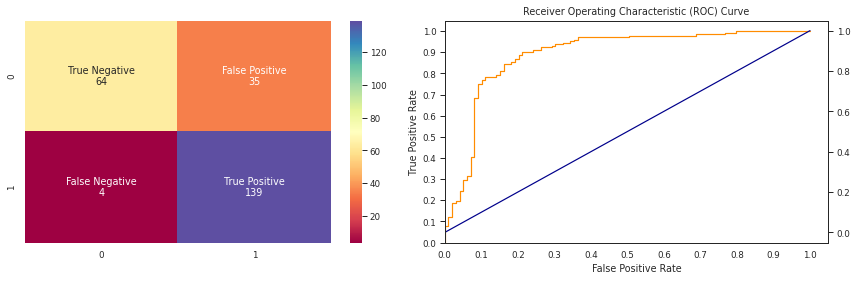

In [ ]:
final_model = LogisticRegressionCV(solver='saga', fit_intercept=False)
final_model.fit(reduced_X_train, y_train)

run_model(final_model, reduced_X_train, reduced_X_test, y_train, y_test)

##**XGBoost Model**

###**Vanilla/Baseline Model**

In [ ]:
y = df['risk_target']
X = df.drop(columns=['county','state','cases','deaths','risk_target'], axis=1)

X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test = train_test_split(X, y, test_size=0.20, random_state=0)


MODEL HYPERPARAMETERS
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 98.44%
Training R-Squared:  0.9844398340248963
Training Root Mean Square Error 0.12474039431997853

Validation accuracy: 85.95%
Validation R-Squared:  0.859504132231405
Validation Root Mean Square Error: 0.37482778414706003

AUC: 0.8740552376916014


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.82      0.85      0.83        99
above averag

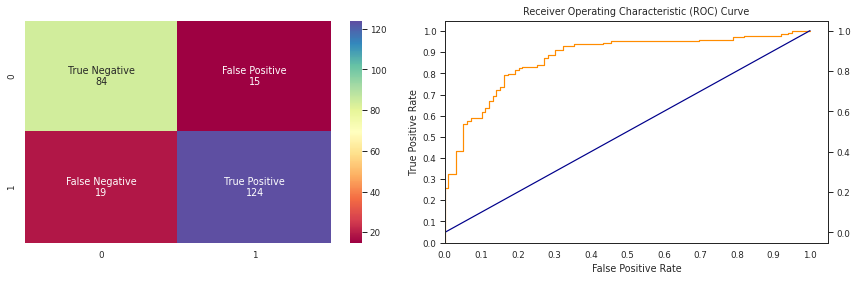

In [ ]:
xgb = XGBClassifier()
run_model(xgb,X_xgb_train, X_xgb_test, y_xgb_train, y_xgb_test)

### **Scaled Data**

In [ ]:
#scale training data
scaler = MinMaxScaler()
transformed_training_features = scaler.fit_transform(X_xgb_train.fillna(0))
X_xgb_train_transformed = pd.DataFrame(transformed_training_features, columns=X_xgb_train.columns)

#scale testing data
scaler = MinMaxScaler()
transformed_testing_features = scaler.fit_transform(X_xgb_test.fillna(0))
X_xgb_test_transformed = pd.DataFrame(transformed_testing_features, columns=X_xgb_test.columns)

X_xgb_train_transformed.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,num_mobile_homes,num_overcrowding,num_households_with_no_vehicle,num_institutionalized_in_group_quarters,percent_below_poverty,percent_unemployed_CDC,percent_no_highschool_diploma,percent_age_65_and_older,percent_age_17_and_younger,percent_disabled,percent_single_parent_households_CDC,percent_minorities,percent_limited_english_abilities,percent_multi_unit_housing,percent_mobile_homes,percent_overcrowding,percent_no_vehicle,percent_institutionalized_in_group_quarters,percentile_rank_below_poverty,percentile_rank_unemployed,percentile_rank_per_capita_income,percentile_rank_no_highschool_diploma,percentile_rank_socioeconomic_theme,percentile_rank_age_65_and_older,percentile_rank_age_17_and_younger,percentile_rank_disabled,percentile_rank_single_parent_households,percentile_rank_household_comp_disability_theme,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,km_to_closest_station,ELEV_M
0,1.0,1.0,0.244057,0.742978,0.026265,0.036238,0.007328,0.338965,0.301194,0.405608,0.287428,0.270990,0.811224,0.656566,0.589595,0.630479,0.469181,0.084282,0.072046,0.366337,0.015750,0.062048,0.351644,0.017684,0.492441,0.010451,0.102853,0.006797,0.031602,0.003140,0.015147,0.278249,0.56,0.677419,0.885263,0.018325,0.020369,0.446352,0.025635,0.021934,...,0.140308,0.014088,0.016176,0.043583,0.305182,0.277592,0.381295,0.350932,0.534375,0.269504,0.337121,0.371755,0.081356,0.029963,0.420755,0.070039,0.057471,0.042339,0.6291,0.6937,0.533920,0.709322,0.685600,0.283754,0.845306,0.211675,0.5810,0.412391,0.765165,0.805606,0.845667,0.300680,0.835636,0.8485,0.3473,0.535961,0.683093,0.745269,0.047178,0.029564
1,1.0,1.0,0.397250,0.709386,0.002216,0.029002,0.000822,0.225635,0.185535,0.277965,0.179349,0.305754,0.533163,0.797980,0.569364,0.360860,0.446445,0.011390,0.005764,0.555556,0.000326,0.017391,0.101407,0.000746,0.235328,0.001100,0.123096,0.001812,0.096918,0.000174,0.009678,0.106111,0.76,0.564516,0.885263,0.001580,0.001541,0.540604,0.001539,0.002050,...,0.004982,0.000281,0.001324,0.002775,0.128599,0.140468,0.110312,0.447205,0.496875,0.301418,0.181818,0.058152,0.000000,0.020599,0.150943,0.013619,0.045977,0.030242,0.0790,0.1678,0.320192,0.052268,0.099348,0.605869,0.731089,0.284970,0.0669,0.253540,0.187988,0.000000,0.054092,0.192716,0.372272,0.0799,0.1907,0.350005,0.032552,0.023831,0.305542,0.105103
2,0.0,0.0,0.447391,0.577248,0.008141,0.083962,0.000991,0.235979,0.249940,0.300716,0.424975,0.317682,0.596939,0.737374,0.473988,0.840184,0.543080,0.009112,0.013689,0.200000,0.001466,0.014203,0.282561,0.004458,0.374290,0.004950,0.158464,0.008156,0.124657,0.012561,0.199160,0.178655,0.36,0.483871,0.745375,0.006540,0.006518,0.529716,0.007519,0.006411,...,0.048430,0.004222,0.003577,0.007607,0.287908,0.214047,0.218225,0.211180,0.665625,0.351064,


MODEL HYPERPARAMETERS
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 98.44%
Training R-Squared:  0.9844398340248963
Training Root Mean Square Error 0.12474039431997853

Validation accuracy: 78.51%
Validation R-Squared:  0.7851239669421488
Validation Root Mean Square Error: 0.463547228508435

AUC: 0.8197358197358198


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.89      0.55      0.67        99
above average

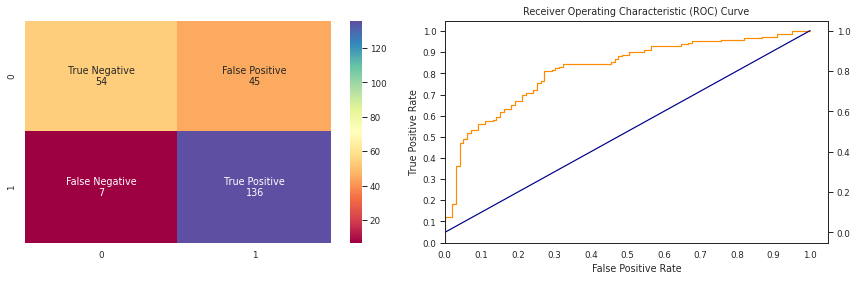

In [ ]:
xgb = XGBClassifier()
run_model(xgb,X_xgb_train_transformed, X_xgb_test_transformed, y_xgb_train, y_xgb_test)

XGB continues to fair better than the LogRegCV model after scaling.

###**Add Polynomial Features**

In [ ]:
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
X_xgb_train_poly = pd.DataFrame(poly.fit_transform(X_xgb_train_transformed), columns=poly.get_feature_names(X_xgb_train_transformed.columns))
X_xgb_test_poly = pd.DataFrame(poly.fit_transform(X_xgb_test_transformed), columns=poly.get_feature_names(X_xgb_test_transformed.columns))

X_xgb_train_poly.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,percentile_rank_multi_unit_housing percentile_rank_housing_and_transportation,percentile_rank_multi_unit_housing percentile_rank_social_vulnerability,percentile_rank_multi_unit_housing km_to_closest_station,percentile_rank_multi_unit_housing ELEV_M,percentile_rank_mobile_homes^2,percentile_rank_mobile_homes percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_no_vehicle,percentile_rank_mobile_homes percentile_rank_institutionalized_in_group_quarters,percentile_rank_mobile_homes percentile_rank_housing_and_transportation,percentile_rank_mobile_homes percentile_rank_social_vulnerability,percentile_rank_mobile_homes km_to_closest_station,percentile_rank_mobile_homes ELEV_M,percentile_rank_overcrowding^2,percentile_rank_overcrowding percentile_rank_no_vehicle,percentile_rank_overcrowding percentile_rank_institutionalized_in_group_quarters,percentile_rank_overcrowding percentile_rank_housing_and_transportation,percentile_rank_overcrowding percentile_rank_social_vulnerability,percentile_rank_overcrowding km_to_closest_station,percentile_rank_overcrowding ELEV_M,percentile_rank_no_vehicle^2,percentile_rank_no_vehicle percentile_rank_institutionalized_in_group_quarters,percentile_rank_no_vehicle percentile_rank_housing_and_transportation,percentile_rank_no_vehicle percentile_rank_social_vulnerability,percentile_rank_no_vehicle km_to_closest_station,percentile_rank_no_vehicle ELEV_M,percentile_rank_institutionalized_in_group_quarters^2,percentile_rank_institutionalized_in_group_quarters percentile_rank_housing_and_transportation,percentile_rank_institutionalized_in_group_quarters percentile_rank_social_vulnerability,percentile_rank_institutionalized_in_group_quarters km_to_closest_station,percentile_rank_institutionalized_in_group_quarters ELEV_M,percentile_rank_housing_and_transportation^2,percentile_rank_housing_and_transportation percentile_rank_social_vulnerability,percentile_rank_housing_and_transportation km_to_closest_station,percentile_rank_housing_and_transportation ELEV_M,percentile_rank_social_vulnerability^2,percentile_rank_social_vulnerability km_to_closest_station,percentile_rank_social_vulnerability ELEV_M,km_to_closest_station^2,km_to_closest_station ELEV_M,ELEV_M^2
0,1.0,1.0,0.244057,0.742978,0.026265,0.036238,0.007328,0.338965,0.301194,0.405608,0.287428,0.270990,0.811224,0.656566,0.589595,0.630479,0.469181,0.084282,0.072046,0.366337,0.015750,0.062048,0.351644,0.017684,0.492441,0.010451,0.102853,0.006797,0.031602,0.003140,0.015147,0.278249,0.56,0.677419,0.885263,0.018325,0.020369,0.446352,0.025635,0.021934,...,0.205393,0.224088,0.014185,0.008889,0.698287,0.709037,0.290216,0.447868,0.570817,0.622773,0.039423,0.024704,0.719952,0.294684,0.454763,0.579604,0.632361,0.040030,0.025085,0.120617,0.186139,0.237238,0.258832,0.016385,0.010267,0.287254,0.366111,0.399435,0.025285,0.015845,0.466616,0.509088,0.032227,0.020195,0.555426,0.035160,0.022033,0.002226,0.001395,0.000874
1,1.0,1.0,0.397250,0.709386,0.002216,0.029002,0.000822,0.225635,0.185535,0.277965,0.179349,0.305754,0.533163,0.797980,0.


MODEL HYPERPARAMETERS
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 76.86%
Validation R-Squared:  0.768595041322314
Validation Root Mean Square Error: 0.48104569292083466

AUC: 0.9166490075580984


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.82      0.56      0.66        99
above average risk       0.75      0.92    

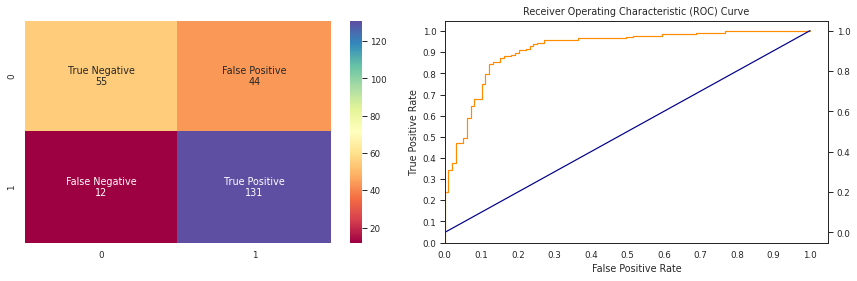

In [ ]:
xgb = XGBClassifier()
run_model(xgb,X_xgb_train_poly, X_xgb_test_poly, y_xgb_train, y_xgb_test)

XGB is doing slightly better in recall than LogRegCV, however it is underpreforming comparatively on precision and recall.

###**Remove Columns from LASSO + VarianceThreshold() Testing**

In [ ]:
X_xgb_train_reduced = pd.DataFrame(X_xgb_train_poly, columns=reduced_X_train.columns)
X_xgb_test_reduced = pd.DataFrame(X_xgb_test_poly, columns=reduced_X_test.columns)
X_xgb_train_reduced.head()

,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,stay_at_home_effective percent_vaccinated,stay_at_home_effective percent_single_parent_households_CHR,stay_at_home_effective social_association_rate,stay_at_home_effective violent_crime_rate,stay_at_home_effective presence_of_water_violation,stay_at_home_effective percent_long_commute_drives_alone,stay_at_home_effective age_adjusted_death_rate,stay_at_home_effective percent_frequent_physical_distress,stay_at_home_effective percent_adults_with_diabetes,...,percent_enrolled_in_free_or_reduced_lunch percentile_rank_no_vehicle,percent_homeowners^2,percent_severe_housing_cost_burden^2,percent_non_hispanic_white percentile_rank_unemployed,percent_non_hispanic_white percentile_rank_multi_unit_housing,percent_non_hispanic_white percentile_rank_overcrowding,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentil


MODEL HYPERPARAMETERS
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 98.13%
Training R-Squared:  0.9813278008298755
Training Root Mean Square Error 0.13664625560228308

Validation accuracy: 80.58%
Validation R-Squared:  0.8057851239669421
Validation Root Mean Square Error: 0.4406981688560299

AUC: 0.8917849826940736


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                    precision    recall  f1-score   support

below average risk       0.82      0.67      0.74        99
above averag

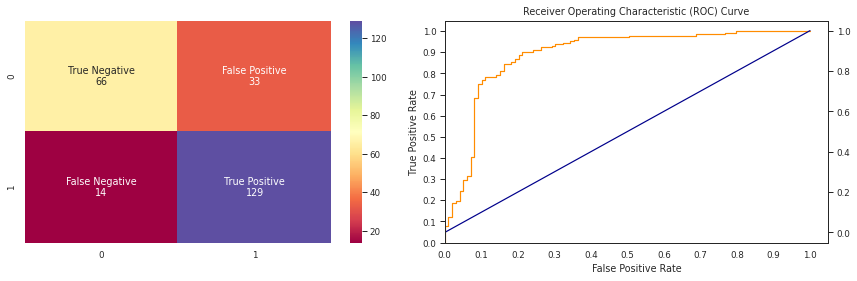

In [ ]:
run_model(xgb,X_xgb_train_reduced, X_xgb_test_reduced, y_xgb_train, y_xgb_test)

After conducting feature selection, the model is now doing worse in precision, recall, and accuracy than the LogRegCV model.

###**GridSearchCV for Parameter Tuning Final Model**

In [ ]:
#Create parameter grid
#param_grid = {
#    "booster": ['gbtree', 'gbliear', 'dart'],
#    "feature_selector": ['cyclic', 'shuffle', 'random', 'greedy', 'thrifty'],
#    "gamma": [0, 1],
#    "learning_rate": [1.0, 0.5],
#    'max_depth': [6, 10],
#    'min_child_weight': [1, 2],
#    'max_delta_step': [1, 2],
#    'normalize_type': ['tree', 'forest'],
#    'num_parallel_tree': [1, 2],
#    'sampling_method': ['uniform', 'gradient_based'],
#    'sample_type': ['uniform','weighted'],
#    'updater': ['shotgun', 'coord_descent', 'grow_colmaker', 'prune'],
#}

#Create grid search object
#clf = GridSearchCV(estimator=XGBClassifier(), param_grid = param_grid, cv = 5, verbose=True, n_jobs=-1)
#clf.fit(X_train_transformed, y_train)

#Find best parameters
#best_parameters = clf.best_params_
#print("Grid Search Found the Following Optimal Parameters: ")
#for param_name in sorted(best_parameters.keys()):
    #print("%s: %r" % (param_name, best_parameters[param_name]))

#########
#RESULTS
##########
#Fitting 5 folds for each of 30720 candidates, totalling 153600 fits
#[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
#[Parallel(n_jobs=-1)]: Done  50 tasks      | elapsed:    8.5s
#[Parallel(n_jobs=-1)]: Done 238 tasks      | elapsed:   52.1s
#[Parallel(n_jobs=-1)]: Done 566 tasks      | elapsed:  2.0min
#...
#[Parallel(n_jobs=-1)]: Done 147883 tasks      | elapsed: 482.3min
#[Parallel(n_jobs=-1)]: Done 152506 tasks      | elapsed: 507.4min
#[Parallel(n_jobs=-1)]: Done 153600 out of 153600 | elapsed: 514.3min finished
#Grid Search Found the Following Optimal Parameters: 
#booster: 'gbtree'
#feature_selector: 'cyclic'
#gamma: 0
#learning_rate: 0.5
#max_delta_step: 2
#max_depth: 10
#min_child_weight: 1
#normalize_type: 'tree'
#num_parallel_tree: 1
#sample_type: 'uniform'
#sampling_method: 'uniform'
#updater: 'grow_colmaker'


MODEL HYPERPARAMETERS
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, feature_selector='cyclic',
              gamma=0, learning_rate=0.5, max_delta_step=2, max_depth=10,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              normalize_type='tree', nthread=None, num_parallel_tree=1,
              objective='binary:logistic', random_state=0, reg_alpha=0,
              reg_lambda=1, sample_type='uniform', sampling_method='uniform',
              scale_pos_weight=1, seed=None, silent=None, subsample=1,
              verbosity=1)


ACCURACY, R-SQUARED, ROOT MEAN SQUARED ERROR, AND AUC
Training Accuracy: 100.0%
Training R-Squared:  1.0
Training Root Mean Square Error 0.0

Validation accuracy: 80.99%
Validation R-Squared:  0.8099173553719008
Validation Root Mean Square Error: 0.43598468393752

AUC: 0.8917849826940736


CLASSIFICATION REPORT, CONFUSION MATRIX and ROC
                

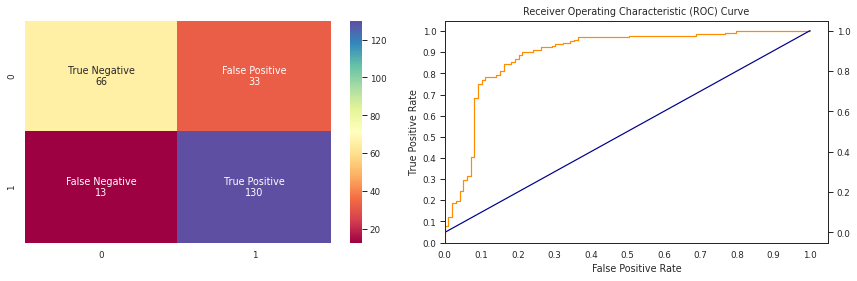

In [ ]:
xgb = XGBClassifier(booster= 'gbtree', feature_selector= 'cyclic', gamma= 0, learning_rate= .5, max_delta_step= 2, max_depth= 10, min_child_weight= 1, 
                    normalize_type= 'tree', num_parallel_tree= 1, sample_type= 'uniform', sampling_method= 'uniform')
run_model(xgb,X_xgb_train_reduced, X_xgb_test_reduced, y_xgb_train, y_xgb_test)

After hyperparameter tuning, the XGB model has underperformed the LogRecCV model. While further experimentation may have solved this issue, given the 500+ minutes it takes to run GridSearchCV(), the time to value ratio didn't favor continuing with the XGB model.

##**Final Model: Inputting X and y into the LogRegCV() Model**

After determining that the Logistic Regression model with the superior model for the data set, I began the process of transforming my original dataframe using the same methods as before, this time with spatial data intact.

In [ ]:
#change yes/no and true/false to 0/1
merged.replace(('yes', 'no'), (1, 0), inplace=True)
merged['presence_of_water_violation'] = merged.presence_of_water_violation.astype(float)

#replace nan values with 0 in num_deaths
merged['num_deaths'] = merged['num_deaths'].fillna(0)

#drop values with more than 10% NaNs:
merged = merged.dropna(thresh=len(merged) * .9, axis=1)

#fill remaining NaNs with median: 
merged = merged.fillna(merged.median())

#drop informational data
merged = merged.drop(['CALL'], axis=1)

#drop data that was used to create "risk_target" metric
merged = merged.drop(['cases_percent_of_pop', 'case_target','cases_1_of_x','deaths_percent_of_pop','death_target',
                      'deaths_1_of_x','num_deaths', 'years_of_potential_life_lost_rate'], axis=1)

merged.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,county,state,risk_target,cases,deaths,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,...,num_overcrowding,num_households_with_no_vehicle,num_institutionalized_in_group_quarters,percent_below_poverty,percent_unemployed_CDC,percent_no_highschool_diploma,percent_age_65_and_older,percent_age_17_and_younger,percent_disabled,percent_single_parent_households_CDC,percent_minorities,percent_limited_english_abilities,percent_multi_unit_housing,percent_mobile_homes,percent_overcrowding,percent_no_vehicle,percent_institutionalized_in_group_quarters,percentile_rank_below_poverty,percentile_rank_unemployed,percentile_rank_per_capita_income,percentile_rank_no_highschool_diploma,percentile_rank_socioeconomic_theme,percentile_rank_age_65_and_older,percentile_rank_age_17_and_younger,percentile_rank_disabled,percentile_rank_single_parent_households,percentile_rank_household_comp_disability_theme,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,km_to_closest_station,ELEV_M,risk
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48081,48,081,01383826,0500000US48081,Coke,06,2361153195,42331832,"POLYGON ((-100.82497 31.74941, -100.82415 31.8...",Coke,Texas,Average Transmission and/or Death,105.0,5.0,1,1,31.888637,-100.529931,3228.0,911.469551,3.541534,18.491390,3.887589,4.118610,6.034483,14.282471,28.8,4.6,29.9,72.349398,16.489287,4.0,15.0,26.666667,14.0,423.5,36.827195,484.0,19.950536,13.0,...,22.0,59.0,119.0,17.2,4.3,14.7,26.6,20.2,18.2,7.8,23.0,1.8,1.2,27.9,1.4,3.8,3.7,0.5976,0.1754,0.2655,0.5982,0.3948,0.9647,0.2139,0.7233,0.3926,0.7135,0.6154,0.7361,0.7100,0.2089,0.9198,0.3130,0.1624,0.7386,0.3992,0.5218,31.409785,608.7,1.0
48273,48,273,01383922,0500000US48273,Kleberg,06,2282572445,541041659,"MULTIPOLYGON (((-97.31780 27.49456, -97.31590 ...",Kleberg,Texas,Average Transmission and/or Death,999.0,51.0,1,1,27.433237,-97.750170,31877.0,881.305785,36.170193,27.932047,4.390527,4.130000,7.773512,15.040413,34.0,6.8,21.4,50.640966,17.790307,3.0,28.0,10.714286,230.0,739.8,35.750871,5023.0,19.745273,14.0,...,626.0,998.0,1973.0,23.8,10.5,22.6,12.7,24.5,15.2,12.4,78.5,4.6,7.0,7.6,5.8,9.3,6.2,0.8752,0.8742,0.8418,0.8876,0.9252,0.1235,0.7698,0.4830,0.9284,0.7243,0.9819,0.9054,0.9682,0.8052,0.3518,0.9494,0.8609,0.8555,0.9866,0.9850,9.940197,15.2,1.0
48203,48,203,01383887,0500000US48203,Harrison,06,2331138836,40651525,"POLYGON ((-94.70215 32.45618, -94.70197 32.467...",Harrison,Texas,Below Average Transmission & Death,1063.0,38.0,1,1,32.548144,-94.371475,66431.0,899.934602,73.817586,18.421328,3.863132,4.066395,7.800175,15.551230,44.2,6.6,31.2,63.047950,17.575217,37.0,101.0,36.633663,294.0,441.0,37.605966,9427.0,17.263987,19.0,...,851.0,1185.0,1398.0,17.7,8.3,17.2,15.2,25.4,12.3,8.9,35.8,2.4,1.6,22.3,3.6,5.0,2.1,0.6291,0.6937,0.5342,0.7084,0.6832,0.2833,0.8456,0.2114,0.5810,0.4107,0.7644,0.8048,0.8411,0.3005,0.8348,0.8485,0.3473,0.5358,0.6823,0.7453,6.679686,108.8,0.0
48223,48,223,01383897,0500000US48223,Hopkins,06,1987629163,65639829,"POLYGON ((-95.86333 33.04989, -95.86

In [ ]:
final_y = merged['risk']
final_X = merged.drop(columns=['county','state','cases','deaths','risk_target', 'STATEFP','COUNTYFP','COUNTYNS','AFFGEOID',
                         'NAME','LSAD','ALAND','AWATER','geometry','risk'], axis=1)
indicies = merged.index.values

In [ ]:
#transform features
scaler = MinMaxScaler()
transformed_features = scaler.fit_transform(final_X.fillna(0))
final_X_transformed = pd.DataFrame(transformed_features, columns=final_X.columns, index=indicies)
final_X_transformed.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,num_mobile_homes,num_overcrowding,num_households_with_no_vehicle,num_institutionalized_in_group_quarters,percent_below_poverty,percent_unemployed_CDC,percent_no_highschool_diploma,percent_age_65_and_older,percent_age_17_and_younger,percent_disabled,percent_single_parent_households_CDC,percent_minorities,percent_limited_english_abilities,percent_multi_unit_housing,percent_mobile_homes,percent_overcrowding,percent_no_vehicle,percent_institutionalized_in_group_quarters,percentile_rank_below_poverty,percentile_rank_unemployed,percentile_rank_per_capita_income,percentile_rank_no_highschool_diploma,percentile_rank_socioeconomic_theme,percentile_rank_age_65_and_older,percentile_rank_age_17_and_younger,percentile_rank_disabled,percentile_rank_single_parent_households,percentile_rank_household_comp_disability_theme,percentile_rank_minorities,percentile_rank_limited_english_abilities,percentile_rank_minority_status_and_language_theme,percentile_rank_multi_unit_housing,percentile_rank_mobile_homes,percentile_rank_overcrowding,percentile_rank_no_vehicle,percentile_rank_institutionalized_in_group_quarters,percentile_rank_housing_and_transportation,percentile_rank_social_vulnerability,km_to_closest_station,ELEV_M
48081,1.0,1.0,0.247217,0.668544,0.000294,0.006251,0.000193,0.315508,0.311827,0.419418,0.146207,0.235333,0.362031,0.46,0.504950,0.723494,0.417008,0.004440,0.003947,0.266667,0.000156,0.063719,0.343929,0.000497,0.561752,0.001757,0.093799,0.000000,0.000000,0.000927,0.050537,0.219982,0.384615,0.677419,0.973104,0.000186,0.000198,0.587904,0.000179,0.000241,...,0.008757,0.000057,0.000169,0.000678,0.295585,0.143813,0.266932,0.461382,0.447802,0.419255,0.295455,0.231855,0.055046,0.022472,0.442155,0.027237,0.043678,0.062395,0.5976,0.1754,0.265280,0.5982,0.3948,0.9647,0.213664,0.7233,0.3926,0.7135,0.6154,0.7361,0.7100,0.209025,0.9198,0.3130,0.1624,0.7386,0.3992,0.5218,0.240705,0.173484
48273,1.0,1.0,0.157594,0.696549,0.003142,0.006043,0.001993,0.602719,0.420847,0.422431,0.227096,0.256634,0.476821,0.68,0.294554,0.506410,0.479515,0.003330,0.007612,0.107143,0.003515,0.115704,0.333266,0.005492,0.555233,0.001893,0.087537,0.001947,0.076772,0.000377,0.018877,0.457248,0.384615,0.532258,0.848037,0.002493,0.002533,0.621020,0.002735,0.002554,...,0.011735,0.001620,0.002866,0.011245,0.422265,0.351171,0.424303,0.178862,0.565934,0.326087,0.469697,0.791331,0.140673,0.131086,0.120444,0.112840,0.106897,0.104553,0.8752,0.8742,0.841753,0.8876,0.9252,0.1235,0.769731,0.4830,0.9284,0.7243,0.9819,0.9054,0.9682,0.805683,0.3518,0.9494,0.8609,0.8555,0.9866,0.9850,0.074419,0.013778
48203,1.0,1.0,0.260483,0.730587,0.006578,0.006171,0.004069,0.313376,0.306525,0.405608,0.228336,0.270990,0.701987,0.66,0.537129,0.630479,0.469181,0.041065,0.028193,0.366337,0.004510,0.066595,0.351644,0.010339,0.476429,0.002569,0.055404,0.001718,0.031602,0.000521,0.012193,0.277413,0.538462,0.677419,0.907208,0.004352,0.005312,0.483662,0.005429,0.005805,...,0.073591,0.002202,0.003403,0.007968,0.305182,0.277592,0.316733,0.229675,0.590659,0.236025,0.337121,0.360887,0.073394,0.029963,

In [ ]:
#add polynomial features
poly = PolynomialFeatures(degree=2, interaction_only=False, include_bias=False)
final_X_poly = pd.DataFrame(poly.fit_transform(final_X_transformed), columns=poly.get_feature_names(final_X_transformed.columns), index=indicies)
final_X_poly.head()

,stay_at_home_announced,stay_at_home_effective,lat,lon,total_population,area_sqmi,population_density_per_sqmi,percent_fair_or_poor_health,average_number_of_physically_unhealthy_days,average_number_of_mentally_unhealthy_days,percent_low_birthweight,percent_smokers,percent_adults_with_obesity,food_environment_index,percent_physically_inactive,percent_with_access_to_exercise_opportunities,percent_excessive_drinking,num_alcohol_impaired_driving_deaths,num_driving_deaths,percent_driving_deaths_with_alcohol_involvement,num_chlamydia_cases,chlamydia_rate,teen_birth_rate,num_uninsured,percent_uninsured,num_primary_care_physicians,primary_care_physicians_rate,num_dentists,dentist_rate,num_mental_health_providers,mental_health_provider_rate,preventable_hospitalization_rate,percent_with_annual_mammogram,percent_vaccinated,high_school_graduation_rate,num_some_college,population,percent_some_college,num_unemployed_CHR,labor_force,...,percentile_rank_multi_unit_housing percentile_rank_housing_and_transportation,percentile_rank_multi_unit_housing percentile_rank_social_vulnerability,percentile_rank_multi_unit_housing km_to_closest_station,percentile_rank_multi_unit_housing ELEV_M,percentile_rank_mobile_homes^2,percentile_rank_mobile_homes percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_no_vehicle,percentile_rank_mobile_homes percentile_rank_institutionalized_in_group_quarters,percentile_rank_mobile_homes percentile_rank_housing_and_transportation,percentile_rank_mobile_homes percentile_rank_social_vulnerability,percentile_rank_mobile_homes km_to_closest_station,percentile_rank_mobile_homes ELEV_M,percentile_rank_overcrowding^2,percentile_rank_overcrowding percentile_rank_no_vehicle,percentile_rank_overcrowding percentile_rank_institutionalized_in_group_quarters,percentile_rank_overcrowding percentile_rank_housing_and_transportation,percentile_rank_overcrowding percentile_rank_social_vulnerability,percentile_rank_overcrowding km_to_closest_station,percentile_rank_overcrowding ELEV_M,percentile_rank_no_vehicle^2,percentile_rank_no_vehicle percentile_rank_institutionalized_in_group_quarters,percentile_rank_no_vehicle percentile_rank_housing_and_transportation,percentile_rank_no_vehicle percentile_rank_social_vulnerability,percentile_rank_no_vehicle km_to_closest_station,percentile_rank_no_vehicle ELEV_M,percentile_rank_institutionalized_in_group_quarters^2,percentile_rank_institutionalized_in_group_quarters percentile_rank_housing_and_transportation,percentile_rank_institutionalized_in_group_quarters percentile_rank_social_vulnerability,percentile_rank_institutionalized_in_group_quarters km_to_closest_station,percentile_rank_institutionalized_in_group_quarters ELEV_M,percentile_rank_housing_and_transportation^2,percentile_rank_housing_and_transportation percentile_rank_social_vulnerability,percentile_rank_housing_and_transportation km_to_closest_station,percentile_rank_housing_and_transportation ELEV_M,percentile_rank_social_vulnerability^2,percentile_rank_social_vulnerability km_to_closest_station,percentile_rank_social_vulnerability ELEV_M,km_to_closest_station^2,km_to_closest_station ELEV_M,ELEV_M^2
48081,1.0,1.0,0.247217,0.668544,0.000294,0.006251,0.000193,0.315508,0.311827,0.419418,0.146207,0.235333,0.362031,0.46,0.504950,0.723494,0.417008,0.004440,0.003947,0.266667,0.000156,0.063719,0.343929,0.000497,0.561752,0.001757,0.093799,0.000000,0.000000,0.000927,0.050537,0.219982,0.384615,0.677419,0.973104,0.000186,0.000198,0.587904,0.000179,0.000241,...,0.083443,0.109069,0.050313,0.036262,0.846032,0.287897,0.149376,0.679364,0.367184,0.479952,0.221400,0.159570,0.097969,0.050831,0.231182,0.124950,0.163323,0.075341,0.054300,0.026374,0.119949,0.064830,0.084740,0.039090,0.028174,0.545530,0.294849,0.385401,0.177785,0.128135,0.159361,0.208303,0.096089,0.069255,0.272275,0.125600,0.090524,0.057939,0.041758,0.030097
48273,1.0,1.0,0.157594,0.696549,0.003142,0.006043,0.001993,0.602719,0.420847,0.422431,0.227096,0.256634,0.476821,0.6

In [ ]:
final_X_reduced = pd.DataFrame(final_X_poly, columns=reduced_X_train.columns, index=indicies)
final_X_reduced.index.name = 'GEOID'
final_X_reduced.head()

,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,stay_at_home_effective percent_vaccinated,stay_at_home_effective percent_single_parent_households_CHR,stay_at_home_effective social_association_rate,stay_at_home_effective violent_crime_rate,stay_at_home_effective presence_of_water_violation,stay_at_home_effective percent_long_commute_drives_alone,stay_at_home_effective age_adjusted_death_rate,stay_at_home_effective percent_frequent_physical_distress,stay_at_home_effective percent_adults_with_diabetes,...,percent_enrolled_in_free_or_reduced_lunch percentile_rank_no_vehicle,percent_homeowners^2,percent_severe_housing_cost_burden^2,percent_non_hispanic_white percentile_rank_unemployed,percent_non_hispanic_white percentile_rank_multi_unit_housing,percent_non_hispanic_white percentile_rank_overcrowding,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentil

In [ ]:
#set map index
map_df = map_df.set_index('GEOID')
map_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry
GEOID,,,,,,,,,
48081,48,081,01383826,0500000US48081,Coke,06,2361153195,42331832,"POLYGON ((-100.82497 31.74941, -100.82415 31.8..."
48273,48,273,01383922,0500000US48273,Kleberg,06,2282572445,541041659,"MULTIPOLYGON (((-97.31780 27.49456, -97.31590 ..."
48203,48,203,01383887,0500000US48203,Harrison,06,2331138836,40651525,"POLYGON ((-94.70215 32.45618, -94.70197 32.467..."
48223,48,223,01383897,0500000US48223,Hopkins,06,1987629163,65639829,"POLYGON ((-95.86333 33.04989, -95.86302 33.065..."
48033,48,033,01383802,0500000US48033,Borden,06,2324366073,22297606,"POLYGON ((-101.69128 32.96184, -101.55743 32.9..."


In [ ]:
#merge dataframes & confirm shape
final_df = pd.merge(map_df, final_X_reduced, left_index=True, right_index=True)
print(final_df.shape)
final_df.head()

(3132, 213)


,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,...,percent_enrolled_in_free_or_reduced_lunch percentile_rank_no_vehicle,percent_homeowners^2,percent_severe_housing_cost_burden^2,percent_non_hispanic_white percentile_rank_unemployed,percent_non_hispanic_white percentile_rank_multi_unit_housing,percent_non_hispanic_white percentile_rank_overcrowding,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentile_rank_limited_english_abilities percentile_rank_no_vehicle,percentile_rank_multi_unit_housing percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_housing_and_transportation,percentile_rank_overcrowding^2,percentile_rank_no_vehicle percentile_rank_institutionalized_in_group_quarters
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

Because in my analysis step I want to create a map that shows the estimated probability that each county is of above average risk, I appended a column with this probability at the end of my dataframe.

In [ ]:
#predict probability for X
final_model.fit(final_X_reduced, final_y)
prediction_of_probability = final_model.predict_proba(final_X_reduced)[:,1]
final_df.loc[indicies,'prediction'] = prediction_of_probability
final_df.head()

,STATEFP,COUNTYFP,COUNTYNS,AFFGEOID,NAME,LSAD,ALAND,AWATER,geometry,percent_smokers,age_adjusted_death_rate,percent_uninsured_3,percentile_rank_age_17_and_younger,ELEV_M,stay_at_home_announced lat,stay_at_home_announced average_number_of_physically_unhealthy_days,stay_at_home_announced percent_physically_inactive,stay_at_home_announced percent_excessive_drinking,stay_at_home_announced percent_driving_deaths_with_alcohol_involvement,stay_at_home_announced percent_vaccinated,stay_at_home_announced percent_single_parent_households_CHR,stay_at_home_announced social_association_rate,stay_at_home_announced violent_crime_rate,stay_at_home_announced presence_of_water_violation,stay_at_home_announced percent_long_commute_drives_alone,stay_at_home_announced age_adjusted_death_rate,stay_at_home_announced percent_frequent_physical_distress,stay_at_home_announced percent_adults_with_diabetes,stay_at_home_announced percent_uninsured_2,stay_at_home_announced percent_non_hispanic_white,stay_at_home_announced percent_minorities,stay_at_home_announced percentile_rank_no_highschool_diploma,stay_at_home_announced percentile_rank_age_17_and_younger,stay_at_home_announced percentile_rank_single_parent_households,stay_at_home_announced percentile_rank_housing_and_transportation,stay_at_home_effective lat,stay_at_home_effective average_number_of_physically_unhealthy_days,stay_at_home_effective percent_physically_inactive,stay_at_home_effective percent_excessive_drinking,stay_at_home_effective percent_driving_deaths_with_alcohol_involvement,...,percent_homeowners^2,percent_severe_housing_cost_burden^2,percent_non_hispanic_white percentile_rank_unemployed,percent_non_hispanic_white percentile_rank_multi_unit_housing,percent_non_hispanic_white percentile_rank_overcrowding,percent_rural^2,percent_rural percentile_rank_age_17_and_younger,percent_rural percentile_rank_disabled,percent_rural percentile_rank_overcrowding,percent_no_highschool_diploma percentile_rank_age_17_and_younger,percentile_rank_below_poverty percentile_rank_no_highschool_diploma,percentile_rank_unemployed percentile_rank_disabled,percentile_rank_unemployed percentile_rank_mobile_homes,percentile_rank_unemployed percentile_rank_overcrowding,percentile_rank_per_capita_income percentile_rank_age_17_and_younger,percentile_rank_per_capita_income percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma^2,percentile_rank_no_highschool_diploma percentile_rank_age_65_and_older,percentile_rank_no_highschool_diploma percentile_rank_minority_status_and_language_theme,percentile_rank_no_highschool_diploma percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_65_and_older^2,percentile_rank_age_65_and_older percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger^2,percentile_rank_age_17_and_younger percentile_rank_household_comp_disability_theme,percentile_rank_age_17_and_younger percentile_rank_minorities,percentile_rank_age_17_and_younger percentile_rank_multi_unit_housing,percentile_rank_age_17_and_younger percentile_rank_institutionalized_in_group_quarters,percentile_rank_age_17_and_younger km_to_closest_station,percentile_rank_disabled^2,percentile_rank_disabled percentile_rank_single_parent_households,percentile_rank_disabled percentile_rank_no_vehicle,percentile_rank_single_parent_households percentile_rank_institutionalized_in_group_quarters,percentile_rank_household_comp_disability_theme percentile_rank_minorities,percentile_rank_minorities percentile_rank_overcrowding,percentile_rank_limited_english_abilities percentile_rank_no_vehicle,percentile_rank_multi_unit_housing percentile_rank_overcrowding,percentile_rank_mobile_homes percentile_rank_housing_and_transportation,percentile_rank_overcrowding^2,percentile_rank_no_vehicle percentile_rank_institutionalized_in_group_quarters,prediction
GEOID,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
48081,48,081,01383826,0500000US48081,Coke,06,236115319

## **Data Analysis**

###**Mapping Probability of Being High Risk**

Without any additional data transformation, I should now be able to create a map that shows the estimated probability of being risk. Before answering the question of WHAT risks lead to this, I wanted to answer the question of WHERE do we expect high risk factors (or, alternatively, low protective factors).

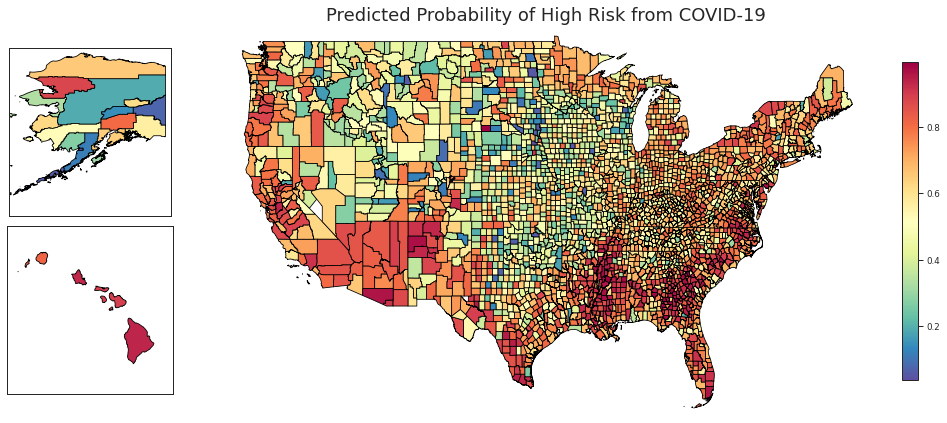

In [ ]:
variable = final_df['prediction']
#build map
fig = plt.figure(figsize=(15, 15))


ax1 = plt.subplot2grid((6,4), (0,1), rowspan=6, colspan=3)
ax1 = final_df.plot(column=variable, cmap='Spectral_r', ax=ax1, edgecolor='black', legend=True, legend_kwds={'shrink': 0.3})
ax1.set_title('Predicted Probability of High Risk from COVID-19', fontsize=18)
ax1.set_xlim(-126, -66)
ax1.set_ylim(24, 50)
ax1.set_xticks([])
ax1.set_yticks([])
ax1.axis('off')
 
ax2 = plt.subplot2grid((6,4), (2,0), rowspan=1, colspan=1)
ax2 = final_df.plot(column=variable, cmap='Spectral_r', ax=ax2, edgecolor='black')
ax2.set_xlim(-170, -140)
ax2.set_ylim(50, 72)
ax2.set_xticks([])
ax2.set_yticks([])
 
ax3 = plt.subplot2grid((6,4), (3,0), rowspan=1, colspan=1)
ax3 = final_df.plot(column=variable, cmap='Spectral_r', ax=ax3, edgecolor='black')
ax3.set_xlim(-161, -154)
ax3.set_ylim(18, 23)
ax3.set_xticks([])
ax3.set_yticks([])

fig.tight_layout()
plt.show();

###**Initial Results Cleaning for Further Exploration**

In [ ]:
final_features = reduced_X_train.columns.tolist()
coefs_ = logreg.coef_.tolist()

#create a dataframe of features and coefficients
results = pd.DataFrame(data=coefs_, columns=final_features)
results = results.T
results = results.rename(columns={0: 'coefficients'})

#add a column for the absolute value of the coefficients
results['abs']=abs(results['coefficients'])

#add a column that is a copy of the index (feature) to be parsed (in the case of polynomial features)
results['features']=results.index

#sort by absolute value of coefficients
results = results.sort_values(by=['abs'], ascending=False)
results.head()

,coefficients,abs,features
percent_physically_inactive percentile_rank_multi_unit_housing,-7.771314,7.771314,percent_physically_inactive percentile_rank_mu...
percent_smokers,7.718032,7.718032,percent_smokers
percent_with_annual_mammogram presence_of_water_violation,6.146270,6.146270,percent_with_annual_mammogram presence_of_wate...
teen_birth_rate percentile_rank_household_comp_disability_theme,6.076735,6.076735,teen_birth_rate percentile_rank_household_comp...
violent_crime_rate presence_of_water_violation,-5.918251,5.918251,violent_crime_rate presence_of_water_violation


In [ ]:
#parse the features column
critical_features = results['features'].str.split(' ')
mlb = MultiLabelBinarizer()
expanded_label_data = mlb.fit_transform(critical_features)
label_classes = mlb.classes_
expanded_labels = pd.DataFrame(expanded_label_data, columns=label_classes)

In [ ]:
#return df with each feature show as a binary categorigal column
results = results.drop(['features'], axis=1)
results = pd.concat([results.reset_index(drop=True), expanded_labels.reset_index(drop=True)], axis=1)
results.head()

,coefficients,abs,ELEV_M,age_adjusted_death_rate,average_daily_pm2_5,average_number_of_mentally_unhealthy_days,average_number_of_physically_unhealthy_days,eightieth_percentile_income,food_environment_index,high_school_graduation_rate,high_school_graduation_rate^2,income_ratio,km_to_closest_station,lat,life_expectancy,lon,lon^2,num_rural,percent_adults_with_diabetes,percent_adults_with_obesity,percent_adults_with_obesity^2,percent_children_in_poverty,percent_driving_deaths_with_alcohol_involvement,percent_enrolled_in_free_or_reduced_lunch,percent_excessive_drinking,percent_excessive_drinking^2,percent_food_insecure,percent_food_insecure^2,percent_frequent_physical_distress,percent_homeowners,percent_homeowners^2,percent_insufficient_sleep^2,percent_limited_access_to_healthy_foods,percent_long_commute_drives_alone,percent_long_commute_drives_alone^2,percent_low_birthweight,percent_minorities,percent_no_highschool_diploma,percent_non_hispanic_white,percent_physically_inactive,...,percent_some_college,percent_uninsured_2,percent_uninsured_3,percent_vaccinated,percent_with_access_to_exercise_opportunities,percent_with_access_to_exercise_opportunities^2,percent_with_annual_mammogram,percentile_rank_age_17_and_younger,percentile_rank_age_17_and_younger^2,percentile_rank_age_65_and_older,percentile_rank_age_65_and_older^2,percentile_rank_below_poverty,percentile_rank_disabled,percentile_rank_disabled^2,percentile_rank_household_comp_disability_theme,percentile_rank_housing_and_transportation,percentile_rank_institutionalized_in_group_quarters,percentile_rank_limited_english_abilities,percentile_rank_minorities,percentile_rank_minority_status_and_language_theme,percentile_rank_mobile_homes,percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma,percentile_rank_no_highschool_diploma^2,percentile_rank_no_vehicle,percentile_rank_overcrowding,percentile_rank_overcrowding^2,percentile_rank_per_capita_income,percentile_rank_single_parent_households,percentile_rank_social_vulnerability,percentile_rank_unemployed,presence_of_water_violation,preventable_hospitalization_rate,severe_housing_cost_burden,social_association_rate,stay_at_home_announced,stay_at_home_effective,teen_birth_rate,twentieth_percentile_income,violent_crime_rate
0,-7.771314,7.771314,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.718032,7.718032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.146270,6.146270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0
3,6.076735,6.076735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,-5.918251,5.918251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1


In [ ]:
#in instances where a feature shows up as feature^2, remove the column and add a 2 in the feature column, then
#create a new column if the column ONLY had value when squared (and thus doesn't already have a column)
clean_columns = results.columns
suffix = '^2'

for column in clean_columns:
  if (str(column).endswith(suffix) == True):
    size = len(column)
    org_string = column
    mod_string = org_string[:size - 2]
    if mod_string in clean_columns:
      results.loc[results[column] > 0, mod_string] = 2
      np.where(results[column] > 0, 2, results[mod_string])
    else:
      results[mod_string] = ''
      results.loc[results[column] > 0, mod_string] = 2
  else: 
    pass

for column in clean_columns:
  if (str(column).endswith(suffix) == True):
    results = results.drop(column, axis=1)

results = results.replace(r'^\s*$', np.nan, regex=True)
results.fillna(0, inplace=True, downcast='infer')

results.head()

,coefficients,abs,ELEV_M,age_adjusted_death_rate,average_daily_pm2_5,average_number_of_mentally_unhealthy_days,average_number_of_physically_unhealthy_days,eightieth_percentile_income,food_environment_index,high_school_graduation_rate,income_ratio,km_to_closest_station,lat,life_expectancy,lon,num_rural,percent_adults_with_diabetes,percent_adults_with_obesity,percent_children_in_poverty,percent_driving_deaths_with_alcohol_involvement,percent_enrolled_in_free_or_reduced_lunch,percent_excessive_drinking,percent_food_insecure,percent_frequent_physical_distress,percent_homeowners,percent_limited_access_to_healthy_foods,percent_long_commute_drives_alone,percent_low_birthweight,percent_minorities,percent_no_highschool_diploma,percent_non_hispanic_white,percent_physically_inactive,percent_rural,percent_single_parent_households_CHR,percent_smokers,percent_some_college,percent_uninsured_2,percent_uninsured_3,percent_vaccinated,percent_with_access_to_exercise_opportunities,percent_with_annual_mammogram,percentile_rank_age_17_and_younger,percentile_rank_age_65_and_older,percentile_rank_below_poverty,percentile_rank_disabled,percentile_rank_household_comp_disability_theme,percentile_rank_housing_and_transportation,percentile_rank_institutionalized_in_group_quarters,percentile_rank_limited_english_abilities,percentile_rank_minorities,percentile_rank_minority_status_and_language_theme,percentile_rank_mobile_homes,percentile_rank_multi_unit_housing,percentile_rank_no_highschool_diploma,percentile_rank_no_vehicle,percentile_rank_overcrowding,percentile_rank_per_capita_income,percentile_rank_single_parent_households,percentile_rank_social_vulnerability,percentile_rank_unemployed,presence_of_water_violation,preventable_hospitalization_rate,severe_housing_cost_burden,social_association_rate,stay_at_home_announced,stay_at_home_effective,teen_birth_rate,twentieth_percentile_income,violent_crime_rate,percent_insufficient_sleep,percent_severe_housing_cost_burden
0,-7.771314,7.771314,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,7.718032,7.718032,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,6.146270,6.146270,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0
3,6.076735,6.076735,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0
4,-5.918251,5.918251,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0


###**Average Coefficient**

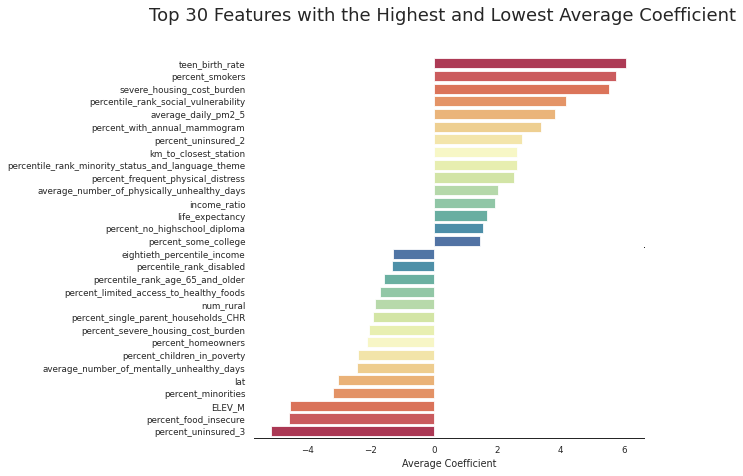

In [ ]:
#make a copy of the df and identify the features with the highest and lowest average coefficients (across all instances they appeared in the model)
coefficients = results.copy()
clean_columns = coefficients.columns

for column in clean_columns:
      coefficients[column] = np.where(coefficients[column]!=0,coefficients['coefficients'],0)

coefficients = coefficients.drop(['coefficients', 'abs'], axis=1)
coefficients = coefficients.T
coefficients = coefficients.replace(0,np.nan)

coefficients['mean_of_coefficients'] = coefficients.mean(axis=1)
coefficients['feature'] = coefficients.index
coefficients = coefficients.sort_values(by=['mean_of_coefficients'], ascending=False)


fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'hspace': 0})
fig.suptitle("Top 30 Features with the Highest and Lowest Average Coefficient", fontsize=18)

risk_plot = sns.barplot(y=coefficients['feature'][0:15], x=coefficients['mean_of_coefficients'], ax=ax[0], palette="Spectral")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
ax[0].set_xlabel('Average Coefficient')
ax[0].set_ylabel('')

risk_plot = sns.barplot(y=coefficients['feature'][-15:], x=coefficients['mean_of_coefficients'], ax=ax[1], palette="Spectral_r")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
ax[1].set_xlabel('Average Coefficient')
ax[1].set_ylabel('')

sns.despine(left=True)
fig.show();

### **Average Absolute Value of Coefficient**

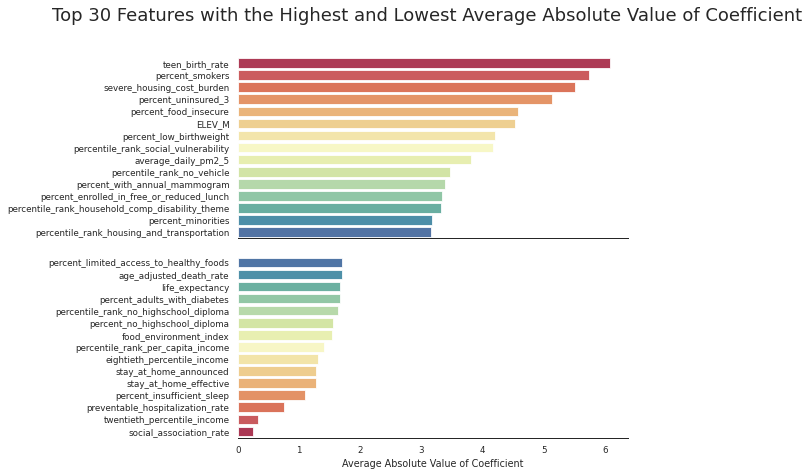

In [ ]:
#make a copy of the df and identify the features with the highest and lowest average absolute value of their 
#coefficients (across all instances they appeared in the model)
absolute = results.copy()
clean_columns = absolute.columns

for column in clean_columns:
      absolute[column] = np.where(absolute[column]!=0,absolute['abs'],0)

absolute = absolute.drop(['coefficients', 'abs'], axis=1)
absolute = absolute.T
absolute = absolute.replace(0,np.nan)

absolute['mean_of_abs'] = absolute.mean(axis=1)
absolute['feature'] = absolute.index
absolute = absolute.sort_values(by=['mean_of_abs'], ascending=False)

fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'hspace': .1})
fig.suptitle("Top 30 Features with the Highest and Lowest Average Absolute Value of Coefficient", fontsize=18)

risk_plot = sns.barplot(y=absolute['feature'][0:15], x=absolute['mean_of_abs'], ax=ax[0], palette="Spectral")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
ax[0].set_xlabel('')
ax[0].set_ylabel('')

risk_plot = sns.barplot(y=absolute['feature'][-15:], x=absolute['mean_of_abs'], ax=ax[1], palette="Spectral_r")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
ax[1].set_xlabel('Average Absolute Value of Coefficient')
ax[1].set_ylabel('')

sns.despine(left=True)
fig.show();

### **Number of Times Feature Used in Model**

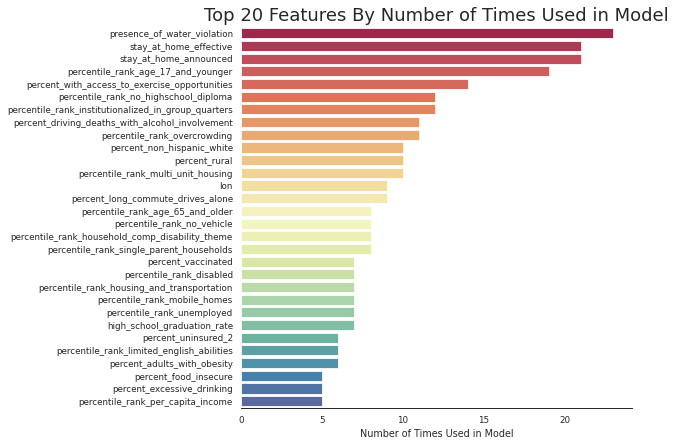

In [ ]:
#make a copy of the df and identify how often each feature was used in the model
findings = results.drop(['coefficients', 'abs'], axis=1)
findings = findings.T

findings['total'] = findings.sum(axis=1).values
findings['feature'] = findings.index
findings = findings.sort_values(by=['total'], ascending=False)

plt.figure(figsize=(7,7))
plt.title("Top 20 Features By Number of Times Used in Model", fontsize=18)
risk_plot = sns.barplot(y=findings['feature'][0:30], x=findings['total'], palette="Spectral")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
risk_plot.set_xlabel('Number of Times Used in Model')
risk_plot.set_ylabel('')
sns.despine(left=True);

# **Conclusions**

###**Don’t Underestimate the Impact of Partisanship**

Politics may play a larger-than-expected role in COVID-19 risk rates. 
* The analysis fails to catch the current prevalence of the virus in the midwest and plains states. 
* In the 2020 election, many of these states leaned or heavily favored the Republican party.

###**Issue Stay-at-Home Orders**

Failure to Issue Stay-at-Home Orders Negate Protective Factors. 
* Stay-at-home orders are amongst the highest used features
* The average of coefficient is close to zero, meaning these features rely on feature interactions for its impact in the model
* A negative coefficient means impact on protective factors
* Stay-at-home orders are binary 0/1 scores


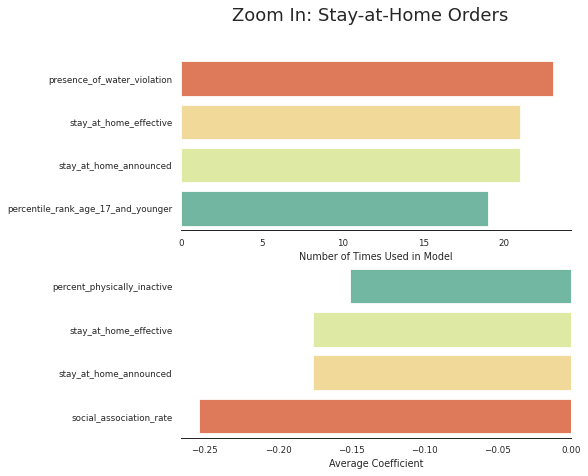

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7))
fig.suptitle("Zoom In: Stay-at-Home Orders", fontsize=18)

risk_plot = sns.barplot(y=findings['feature'][0:4], x=findings['total'], ax=ax[0],palette="Spectral")
ax[0].set_yticklabels(risk_plot.get_yticklabels())
ax[0].set_xlabel('Number of Times Used in Model')
ax[0].set_ylabel('')

risk_plot = sns.barplot(y=coefficients['feature'][-28:-24], x=coefficients['mean_of_coefficients'], ax=ax[1], palette="Spectral_r")
ax[1].set_yticklabels(risk_plot.get_yticklabels())
ax[1].set_xlabel('Average Coefficient')
ax[1].set_ylabel('')

sns.despine(left=True)
fig.show();

###**Focus on Areas with Extreme Poverty**

Many underlying risk factors are positively correlated with poverty
* **Teen Birth Rate:** Percent of women aged 15-19 who give birth in a calendar year
* **Percent Smokers:** Percent of residents 18 years or older who smoke cigarettes or use tobacco products
* **Severe Housing Cost Burden:** Citizens who pay more than 30% of their income for housing
* **Percent Food Insecure:** Percent of residents whose food intake is disrupted do to lack of money or resources
* **Percent Uninsured 3:** Percent of residents who are uninsured (3 month rolling average)


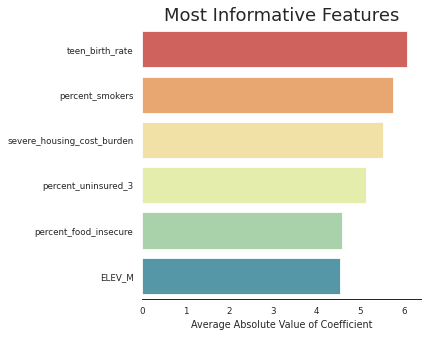

In [ ]:
plt.figure(figsize=(5,5))
plt.title("Most Informative Features", fontsize=18)
risk_plot = sns.barplot(y=absolute['feature'][0:6], x=absolute['mean_of_abs'], palette="Spectral")
risk_plot.set_yticklabels(risk_plot.get_yticklabels())
risk_plot.set_xlabel('Average Absolute Value of Coefficient')
risk_plot.set_ylabel('')
sns.despine(left=True)

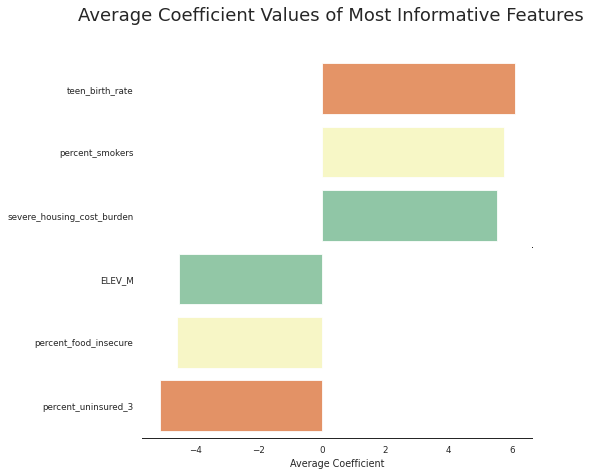

In [ ]:
fig, ax = plt.subplots(2, 1, figsize=(7, 7), sharex=True, gridspec_kw={'hspace': 0})
fig.suptitle("Average Coefficient Values of Most Informative Features", fontsize=18)

risk_plot = sns.barplot(y=coefficients['feature'][0:3], x=coefficients['mean_of_coefficients'], ax=ax[0], palette="Spectral")
ax[0].set_yticklabels(risk_plot.get_yticklabels())
ax[0].set_xlabel('Average Coefficient')
ax[0].set_ylabel('')

risk_plot = sns.barplot(y=coefficients['feature'][-3:], x=coefficients['mean_of_coefficients'], ax=ax[1], palette="Spectral_r")
ax[1].set_yticklabels(risk_plot.get_yticklabels())
ax[1].set_xlabel('Average Coefficient')
ax[1].set_ylabel('')

sns.despine(left=True)
fig.show();

# **Potential for Future Research**

**How do politics impact risk rates?**
<br>Analysis should be conducted on the impact of political affiliation, given the president’s divisive rhetoric about the pandemic. Does this explain certain regions being impacted more than we would expect?

**How does climate impact risk rates?**
<br>Analysis should be conducted to see if certain climate and/or weather patterns either increase or decrease risk rates. While this was originally in scope for this project, due to high quantities of missing data, it was eventually excluded.

**What are the best interventions for high-risk areas?**
<br>Analysis should be conducted to determine what might most effectively mitigate identified risk factors: increased access to health resources, increased access to virus/pandemic education, or improved social safety net programs. Answering the question of “where” resources are allocated doesn’t answer “how.”
